# 心臟肌肉影像分割 - 訓練模型

這個 notebook 用於訓練 Residual U-Net 模型進行心臟肌肉影像分割

## 資料資訊
- 影像維度: 512 x 512 x 341
- 標籤類別: 4 類 (0: 背景, 1-3: 不同心臟組織)
- 訓練資料: 50 筆


## 1. 安裝必要套件


In [1]:
# 如果尚未安裝，請執行以下指令
!pip install torch torchvision nibabel numpy scikit-learn matplotlib tqdm scipy


## 2. 匯入套件


In [2]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# 設定隨機種子
torch.manual_seed(42)
np.random.seed(42)

# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')
if torch.cuda.is_available():
    print(f'GPU 名稱: {torch.cuda.get_device_name(0)}')


使用裝置: cuda
GPU 名稱: NVIDIA A100-SXM4-40GB


## 3. 資料集類別


In [3]:
class Augmentation3D:
    """3D 醫學影像資料增強"""

    def __init__(self,
                 rotation_range=15,      # 旋轉角度範圍（度）
                 flip_prob=0.5,          # 翻轉機率
                 noise_prob=0.3,         # 加噪聲機率
                 brightness_range=0.2,   # 亮度調整範圍
                 contrast_range=0.2):    # 對比度調整範圍
        self.rotation_range = rotation_range
        self.flip_prob = flip_prob
        self.noise_prob = noise_prob
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range

        # Try to initialize torchio
        try:
            import torchio as tio
            self.elastic_transform = tio.RandomElasticDeformation(num_control_points=7, max_displacement=10, p=1.0)
            self.elastic_prob = 0.5 # 設定機率
            self.has_torchio = True
        except ImportError:
            print('Warning: torchio not found')
            self.has_torchio = False

    def __call__(self, image, label):
        """應用隨機增強"""
        # 1. 隨機旋轉（沿 Z 軸，即軸向）
        if np.random.random() < 0.5:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            image = self.rotate_3d(image, angle)
            label = self.rotate_3d(label, angle, is_label=True)

        # 2. 隨機翻轉（左右翻轉）
        if np.random.random() < self.flip_prob:
            image = np.flip(image, axis=0).copy()
            label = np.flip(label, axis=0).copy()

        # 3. 隨機翻轉（前後翻轉）
        if np.random.random() < self.flip_prob:
            image = np.flip(image, axis=1).copy()
            label = np.flip(label, axis=1).copy()

        # 4. 隨機加高斯噪聲
        if np.random.random() < self.noise_prob:
            noise = np.random.normal(0, 0.05, image.shape)
            image = np.clip(image + noise, 0, 1)

        # 5. 隨機亮度調整
        if np.random.random() < 0.5:
            factor = 1 + np.random.uniform(-self.brightness_range, self.brightness_range)
            image = np.clip(image * factor, 0, 1)

        # 6. 隨機對比度調整
        if np.random.random() < 0.5:
            factor = 1 + np.random.uniform(-self.contrast_range, self.contrast_range)
            mean = image.mean()
            image = np.clip((image - mean) * factor + mean, 0, 1)

        # 7. Elastic Deformation
        if hasattr(self, 'has_torchio') and self.has_torchio and np.random.random() < self.elastic_prob:
            import torchio as tio
            # torchio expects (C, W, H, D)
            image_tensor = image[np.newaxis, ...]
            label_tensor = label[np.newaxis, ...]
            subject = tio.Subject(image=tio.ScalarImage(tensor=image_tensor), label=tio.LabelMap(tensor=label_tensor))
            transformed = self.elastic_transform(subject)
            image = transformed['image'].data.numpy()[0]
            label = transformed['label'].data.numpy()[0]

        return image, label

    def rotate_3d(self, volume, angle, is_label=False):
        """3D 旋轉（沿 Z 軸）"""
        from scipy import ndimage
        # 只旋轉 XY 平面（axes=(0,1)），保持 Z 軸不變
        if is_label:
            rotated = ndimage.rotate(volume, angle, axes=(0, 1), reshape=False, order=0, mode='nearest')
        else:
            rotated = ndimage.rotate(volume, angle, axes=(0, 1), reshape=False, order=1, mode='nearest')
        return rotated


class PatchBasedHeartDataset(Dataset):
    """
    Patch-based 心臟影像分割資料集（優化版）

    特點：
    - 從完整的 3D 影像中隨機抽取固定大小的 patches
    - 每個 volume 可以產生多個 patches，增加訓練樣本數
    - 使用更高解析度（256x256x128），保留更多細節
    - 智能採樣：優先採樣包含前景（心臟組織）的區域
    - ⚡ 優化：預先載入和降採樣所有影像（在 __init__ 中執行一次）
    """

    def __init__(self, image_paths, label_paths,
                 patch_size=(96, 96, 96),
                 samples_per_volume=4,
                 augment=False,
                 foreground_ratio=0.7):
        """
        Args:
            image_paths: 影像檔案路徑列表
            label_paths: 標籤檔案路徑列表
            patch_size: Patch 大小 (H, W, D)
            samples_per_volume: 每個 volume 抽取的 patch 數量
            augment: 是否進行資料增強
            foreground_ratio: 前景採樣比例（70% 從前景區域採樣）
        """
        self.patch_size = patch_size
        self.samples_per_volume = samples_per_volume
        self.augment = augment
        self.foreground_ratio = foreground_ratio

        # 初始化增強器
        if self.augment:
            self.augmentor = Augmentation3D(
                rotation_range=15,
                flip_prob=0.5,
                noise_prob=0.3,
                brightness_range=0.2,
                contrast_range=0.2
            )

        # ⚡ 優化：預先載入、正規化和降採樣所有影像（只執行一次）
        print(f'⚡ 預先載入和處理 {len(image_paths)} 個 volumes...')
        self.images = []
        self.labels = []

        from scipy import ndimage
        target_size = (320, 320, 160)

        for i, (img_path, label_path) in enumerate(tqdm(
            zip(image_paths, label_paths),
            total=len(image_paths),
            desc='載入資料'
        )):
            # 讀取原始影像和標籤
            image = nib.load(img_path).get_fdata()
            label = nib.load(label_path).get_fdata()

            # 正規化影像
            image = self.normalize(image)

            # 降採樣到目標解析度
            zoom_factors = [target_size[i] / image.shape[i] for i in range(3)]
            image = ndimage.zoom(image, zoom_factors, order=1)
            label = ndimage.zoom(label, zoom_factors, order=0)

            # 儲存到記憶體
            self.images.append(image)
            self.labels.append(label)

        print(f'✅ 完成！所有資料已預先處理並載入記憶體')
        print(f'   - 影像形狀: {self.images[0].shape}')
        print(f'   - 記憶體使用: ~{len(self.images) * self.images[0].nbytes / (1024**3):.2f} GB')

    def __len__(self):
        # 總樣本數 = volume 數量 × 每個 volume 的 patch 數
        return len(self.images) * self.samples_per_volume

    def __getitem__(self, idx):
        # 計算對應的 volume index
        volume_idx = idx // self.samples_per_volume

        # ⚡ 直接從記憶體取得預處理好的影像（無需 I/O 和降採樣）
        image = self.images[volume_idx]
        label = self.labels[volume_idx]

        # 隨機抽取 patch
        image_patch, label_patch = self.extract_random_patch(image, label)

        # 資料增強（僅在訓練時）
        if self.augment:
            image_patch, label_patch = self.augmentor(image_patch, label_patch)

        # 轉換為 tensor
        image_patch = torch.from_numpy(image_patch).float().unsqueeze(0)  # (1, H, W, D)
        label_patch = torch.from_numpy(label_patch).long()  # (H, W, D)

        return image_patch, label_patch

    def extract_random_patch(self, image, label):
        """
        從完整影像中隨機抽取一個 patch
        智能採樣：70% 機率從前景區域採樣，30% 從任意位置採樣
        """
        h, w, d = image.shape
        ph, pw, pd = self.patch_size

        # 決定採樣策略
        if np.random.random() < self.foreground_ratio and label.sum() > 0:
            # 從前景區域採樣
            foreground_coords = np.where(label > 0)
            if len(foreground_coords[0]) > 0:
                # 隨機選擇一個前景點作為中心
                idx = np.random.randint(0, len(foreground_coords[0]))
                center_h = foreground_coords[0][idx]
                center_w = foreground_coords[1][idx]
                center_d = foreground_coords[2][idx]

                # 以前景點為中心，添加隨機偏移
                start_h = np.clip(center_h - ph // 2 + np.random.randint(-ph//4, ph//4), 0, h - ph)
                start_w = np.clip(center_w - pw // 2 + np.random.randint(-pw//4, pw//4), 0, w - pw)
                start_d = np.clip(center_d - pd // 2 + np.random.randint(-pd//4, pd//4), 0, d - pd)
            else:
                # 如果沒有前景，使用隨機採樣
                start_h = np.random.randint(0, max(1, h - ph))
                start_w = np.random.randint(0, max(1, w - pw))
                start_d = np.random.randint(0, max(1, d - pd))
        else:
            # 完全隨機採樣
            start_h = np.random.randint(0, max(1, h - ph))
            start_w = np.random.randint(0, max(1, w - pw))
            start_d = np.random.randint(0, max(1, d - pd))

        # 提取 patch
        image_patch = image[start_h:start_h+ph, start_w:start_w+pw, start_d:start_d+pd]
        label_patch = label[start_h:start_h+ph, start_w:start_w+pw, start_d:start_d+pd]

        return image_patch, label_patch

    def normalize(self, image):
        """正規化影像到 [0, 1]"""
        image = image.astype(np.float32)
        p1, p99 = np.percentile(image, (1, 99))
        image = np.clip(image, p1, p99)
        image = (image - p1) / (p99 - p1 + 1e-8)
        return image


## 4. 3D U-Net 模型


In [4]:
class Conv3DBlock(nn.Module):
    """3D 卷積區塊"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class ResConv3DBlock(nn.Module):
    """
    3D 殘差卷積區塊 (Residual 3D Convolution Block)

    引入殘差連接 (Skip Connection) 解決梯度消失問題，讓模型能學得更深、更細。

    結構：
    - 主路徑：Conv3d → BN → ReLU → Conv3d → BN
    - 殘差路徑：如果 in_channels != out_channels，使用 1x1x1 卷積匹配維度
    - 輸出：主路徑 + 殘差路徑 → ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # 主路徑：兩個 3x3x3 卷積
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # 殘差路徑：如果輸入輸出通道數不同，使用 1x1x1 卷積匹配維度
        if in_channels != out_channels:
            self.residual_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = None

        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # 保存殘差連接的輸入
        residual = x

        # 主路徑
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 殘差連接：如果維度不匹配，先通過 1x1x1 卷積
        if self.residual_conv is not None:
            residual = self.residual_conv(residual)

        # 主路徑 + 殘差路徑
        out = out + residual

        # 最終 ReLU
        out = self.relu2(out)

        return out


class UNet3D(nn.Module):
    """
    3D Residual U-Net 模型 (ResUNet)

    使用 ResConv3DBlock 替代傳統 Conv3DBlock，引入殘差連接：
    - 解決梯度消失問題
    - 讓模型能學得更深、更細
    - 提升訓練穩定性和收斂速度
    """
    def __init__(self, in_channels=1, num_classes=4, base_channels=32):
        super().__init__()

        # Encoder - 使用 ResConv3DBlock
        self.enc1 = ResConv3DBlock(in_channels, base_channels)
        self.enc2 = ResConv3DBlock(base_channels, base_channels * 2)
        self.enc3 = ResConv3DBlock(base_channels * 2, base_channels * 4)
        self.enc4 = ResConv3DBlock(base_channels * 4, base_channels * 8)

        # Bottleneck - 使用 ResConv3DBlock
        self.bottleneck = ResConv3DBlock(base_channels * 8, base_channels * 16)

        # Decoder - 使用 ResConv3DBlock
        self.upconv4 = nn.ConvTranspose3d(base_channels * 16, base_channels * 8, kernel_size=2, stride=2)
        self.dec4 = ResConv3DBlock(base_channels * 16, base_channels * 8)

        self.upconv3 = nn.ConvTranspose3d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = ResConv3DBlock(base_channels * 8, base_channels * 4)

        self.upconv2 = nn.ConvTranspose3d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = ResConv3DBlock(base_channels * 4, base_channels * 2)

        self.upconv1 = nn.ConvTranspose3d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = ResConv3DBlock(base_channels * 2, base_channels)

        # Output
        self.out = nn.Conv3d(base_channels, num_classes, kernel_size=1)

        # Pooling
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return self.out(dec1)


In [5]:
class DiceLoss(nn.Module):
    """Dice Loss for multi-class segmentation"""
    def __init__(self, num_classes=4):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        dice_loss = 0

        for i in range(self.num_classes):
            pred_i = pred[:, i]
            target_i = (target == i).float()

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice_loss += 1 - (2 * intersection + 1e-7) / (union + 1e-7)

        return dice_loss / self.num_classes


class BoundaryLoss(nn.Module):
    """
    邊界損失 (Boundary Loss) - 專門懲罰邊緣錯誤

    核心思想：
    1. 檢測預測和真實標籤的邊界
    2. 計算邊界區域的預測錯誤
    3. 對邊界錯誤給予更高的懲罰權重

    這有助於：
    - 提升分割邊界的精確度
    - 縮小 IoU 與 Dice 的差距
    - 減少邊緣的模糊和錯誤
    """
    def __init__(self, num_classes=4):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, target):
        """
        計算邊界損失

        Args:
            pred: 模型預測 (B, C, H, W, D)
            target: 真實標籤 (B, H, W, D)
        """
        import torch.nn.functional as F

        pred_softmax = torch.softmax(pred, dim=1)
        boundary_loss = 0

        for i in range(self.num_classes):
            # 取得當前類別的預測和真實標籤
            pred_i = pred_softmax[:, i]  # (B, H, W, D)
            target_i = (target == i).float()  # (B, H, W, D)

            # 計算邊界 (使用梯度檢測)
            # 對真實標籤計算梯度，梯度大的地方就是邊界
            target_boundary = self.compute_boundary(target_i)

            # 在邊界區域計算預測錯誤
            # 使用 BCE loss 在邊界區域
            boundary_error = F.binary_cross_entropy(
                pred_i,
                target_i,
                reduction='none'
            )

            # 只關注邊界區域的錯誤（給予更高權重）
            weighted_error = boundary_error * (1 + 2 * target_boundary)
            # 邊界區域權重 = 3, 非邊界區域權重 = 1

            boundary_loss += weighted_error.mean()

        return boundary_loss / self.num_classes

    def compute_boundary(self, mask):
        """
        計算 3D mask 的邊界
        使用 3D Sobel 算子檢測邊界

        Args:
            mask: (B, H, W, D) 二值 mask
        Returns:
            boundary: (B, H, W, D) 邊界 map，邊界處值較大
        """
        import torch.nn.functional as F

        # 使用簡單的梯度檢測
        # 計算三個方向的差分
        grad_x = torch.abs(mask[:, 1:, :, :] - mask[:, :-1, :, :])
        grad_y = torch.abs(mask[:, :, 1:, :] - mask[:, :, :-1, :])
        grad_z = torch.abs(mask[:, :, :, 1:] - mask[:, :, :, :-1])

        # Pad 回原始大小
        grad_x = F.pad(grad_x, (0, 0, 0, 0, 0, 1))
        grad_y = F.pad(grad_y, (0, 0, 0, 1, 0, 0))
        grad_z = F.pad(grad_z, (0, 1, 0, 0, 0, 0))

        # 合併三個方向的梯度
        boundary = (grad_x + grad_y + grad_z) > 0

        return boundary.float()


class CombinedLoss(nn.Module):
    """
    結合 CrossEntropy、Dice Loss 和 Boundary Loss

    配置：
    - CE (50%): 基礎的像素級分類損失 + 類別權重
    - Dice (30%): 整體區域重疊損失
    - Boundary (20%): 邊界精確度損失

    新增功能：
    - ⭐ CrossEntropy 類別權重：處理類別不平衡
    """
    def __init__(self, num_classes=4, weight_ce=0.4, weight_dice=0.3, weight_boundary=0.3,
                 class_weights=None, device='cuda'):
        super().__init__()

        # ⭐ 類別權重：處理類別不平衡問題
        if class_weights is None:
            # 預設權重：基於醫學影像分割經驗
            # 背景（class 0）權重較低，心臟組織（class 1-3）權重較高
            class_weights = torch.tensor([0.5, 1.5, 1.5, 1.5], dtype=torch.float32)
            print(f'🎯 使用預設類別權重：')
            print(f'   - 背景 (class 0): {class_weights[0]:.1f}')
            print(f'   - 心臟組織 (class 1-3): {class_weights[1]:.1f}')

        # ⭐ 重要：將權重移到正確的設備（GPU）
        if isinstance(class_weights, torch.Tensor):
            class_weights = class_weights.to(device)

        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.dice = DiceLoss(num_classes)
        self.boundary = BoundaryLoss(num_classes)
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.weight_boundary = weight_boundary

        print(f'\n📊 損失函數配置：')
        print(f'   CrossEntropy: {weight_ce:.1%} (含類別權重 ⭐)')
        print(f'   Dice Loss: {weight_dice:.1%}')
        print(f'   Boundary Loss: {weight_boundary:.1%}')

    def forward(self, pred, target):
        ce_loss = self.ce(pred, target)
        dice_loss = self.dice(pred, target)
        boundary_loss = self.boundary(pred, target)

        return (self.weight_ce * ce_loss +
                self.weight_dice * dice_loss +
                self.weight_boundary * boundary_loss)


def dice_coefficient(pred, target, num_classes=4):
    """計算 Dice 係數"""
    pred = torch.argmax(pred, dim=1)
    dice_scores = []

    for i in range(1, num_classes):  # 跳過背景
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        if union > 0:
            dice = (2 * intersection) / (union + 1e-7)
            dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0


def iou_coefficient(pred, target, num_classes=4):
    """
    計算 IoU 係數 (Intersection over Union)
    IoU = Intersection / Union
    """
    pred = torch.argmax(pred, dim=1)
    iou_scores = []

    for i in range(1, num_classes):  # 跳過背景
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum() - intersection

        if union > 0:
            iou = intersection / (union + 1e-7)
            iou_scores.append(iou.item())

    return np.mean(iou_scores) if iou_scores else 0.0


def combined_score(pred, target, num_classes=4):
    """
    計算 Combined Score = (Dice + IoU) / 2
    這是比賽的評分標準
    """
    dice = dice_coefficient(pred, target, num_classes)
    iou = iou_coefficient(pred, target, num_classes)
    return (dice + iou) / 2.0


## 準備資料


## 5. 掛載 Google Drive (如果資料在雲端硬碟)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

# 假設您的資料夾結構是 /content/gdrive/MyDrive/aicup_data/training_image 和 /content/gdrive/MyDrive/aicup_data/training_label
# 請根據您的實際路徑調整
base_data_dir = '/content/gdrive/MyDrive/aicup_data'
image_dir = os.path.join(base_data_dir, 'training_image')
label_dir = os.path.join(base_data_dir, 'training_label')

# 檢查資料夾是否存在
if not os.path.exists(image_dir):
    print(f"錯誤：影像資料夾 '{image_dir}' 不存在。請檢查路徑或將資料上傳到指定位置。")
if not os.path.exists(label_dir):
    print(f"錯誤：標籤資料夾 '{label_dir}' 不存在。請檢查路徑或將資料上傳到指定位置。")

print(f'影像資料夾路徑: {image_dir}')
print(f'標籤資料夾路徑: {label_dir}')

Mounted at /content/gdrive
影像資料夾路徑: /content/gdrive/MyDrive/aicup_data/training_image
標籤資料夾路徑: /content/gdrive/MyDrive/aicup_data/training_label


In [7]:
# 取得所有訓練資料路徑
# image_dir 和 label_dir 變數已在前面的儲存格中設定為 Google Drive 路徑

image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
label_paths = sorted(glob.glob(os.path.join(label_dir, '*.nii.gz')))

print(f'找到 {len(image_paths)} 個訓練影像')
print(f'找到 {len(label_paths)} 個訓練標籤')

# 檢查配對
for img_path, lbl_path in zip(image_paths[:3], label_paths[:3]):
    print(f'影像: {os.path.basename(img_path)} <-> 標籤: {os.path.basename(lbl_path)}')


找到 50 個訓練影像
找到 50 個訓練標籤
影像: patient0001.nii.gz <-> 標籤: patient0001_gt.nii.gz
影像: patient0002.nii.gz <-> 標籤: patient0002_gt.nii.gz
影像: patient0003.nii.gz <-> 標籤: patient0003_gt.nii.gz


In [8]:
# 分割訓練集和驗證集
train_images, val_images, train_labels, val_labels = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

print(f'訓練集: {len(train_images)} 筆')
print(f'驗證集: {len(val_images)} 筆')

# ==================== Patch-based Training 配置 ====================
print('\n' + '='*70)
print('🎯 使用 Patch-based Training 策略')
print('='*70)

# Patch 配置
PATCH_SIZE = (112, 112, 112)  # Patch 大小（比完整降採樣更小但解析度更高）
SAMPLES_PER_VOLUME = 4     # 每個 volume 抽取 4 個 patches
BATCH_SIZE = 4             # Patch-based 可以使用更大的 batch size

print(f'\n📦 Patch 配置：')
print(f'   - Patch 大小: {PATCH_SIZE}')
print(f'   - 每個 volume 的 patch 數: {SAMPLES_PER_VOLUME}')
print(f'   - 批次大小: {BATCH_SIZE}')
print(f'   - 訓練樣本數: {len(train_images)} volumes × {SAMPLES_PER_VOLUME} = {len(train_images) * SAMPLES_PER_VOLUME} patches')
print(f'   - 驗證樣本數: {len(val_images)} volumes × {SAMPLES_PER_VOLUME} = {len(val_images) * SAMPLES_PER_VOLUME} patches')

# 建立 Patch-based 資料集
train_dataset = PatchBasedHeartDataset(
    train_images, train_labels,
    patch_size=PATCH_SIZE,
    samples_per_volume=SAMPLES_PER_VOLUME,
    augment=True,
    foreground_ratio=0.7  # 70% 從前景區域採樣
)

val_dataset = PatchBasedHeartDataset(
    val_images, val_labels,
    patch_size=PATCH_SIZE,
    samples_per_volume=SAMPLES_PER_VOLUME,
    augment=False,
    foreground_ratio=0.5  # 驗證時降低前景採樣比例，更全面評估
)

print('\n✅ 訓練集已啟用智能 Patch 採樣 + 3D 資料增強：')
print('   🎲 智能採樣：70% 從前景（心臟）區域採樣')
print('   🔄 隨機旋轉（±15度）')
print('   🔁 隨機翻轉（左右、前後）')
print('   📊 隨機高斯噪聲')
print('   💡 隨機亮度調整（±20%）')
print('   🌗 隨機對比度調整（±20%）')

# 建立資料載入器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f'\n訓練 batches: {len(train_loader)}')
print(f'驗證 batches: {len(val_loader)}')


訓練集: 40 筆
驗證集: 10 筆

🎯 使用 Patch-based Training 策略

📦 Patch 配置：
   - Patch 大小: (112, 112, 112)
   - 每個 volume 的 patch 數: 4
   - 批次大小: 4
   - 訓練樣本數: 40 volumes × 4 = 160 patches
   - 驗證樣本數: 10 volumes × 4 = 40 patches
⚡ 預先載入和處理 40 個 volumes...


載入資料: 100%|██████████| 40/40 [08:36<00:00, 12.92s/it]


✅ 完成！所有資料已預先處理並載入記憶體
   - 影像形狀: (320, 320, 160)
   - 記憶體使用: ~4.88 GB
⚡ 預先載入和處理 10 個 volumes...


載入資料: 100%|██████████| 10/10 [01:56<00:00, 11.64s/it]

✅ 完成！所有資料已預先處理並載入記憶體
   - 影像形狀: (320, 320, 160)
   - 記憶體使用: ~1.22 GB

✅ 訓練集已啟用智能 Patch 採樣 + 3D 資料增強：
   🎲 智能採樣：70% 從前景（心臟）區域採樣
   🔄 隨機旋轉（±15度）
   🔁 隨機翻轉（左右、前後）
   📊 隨機高斯噪聲
   💡 隨機亮度調整（±20%）
   🌗 隨機對比度調整（±20%）

訓練 batches: 40
驗證 batches: 10


## 7. 視覺化資料


展示資料增強效果（同一張影像的 4 次不同增強）



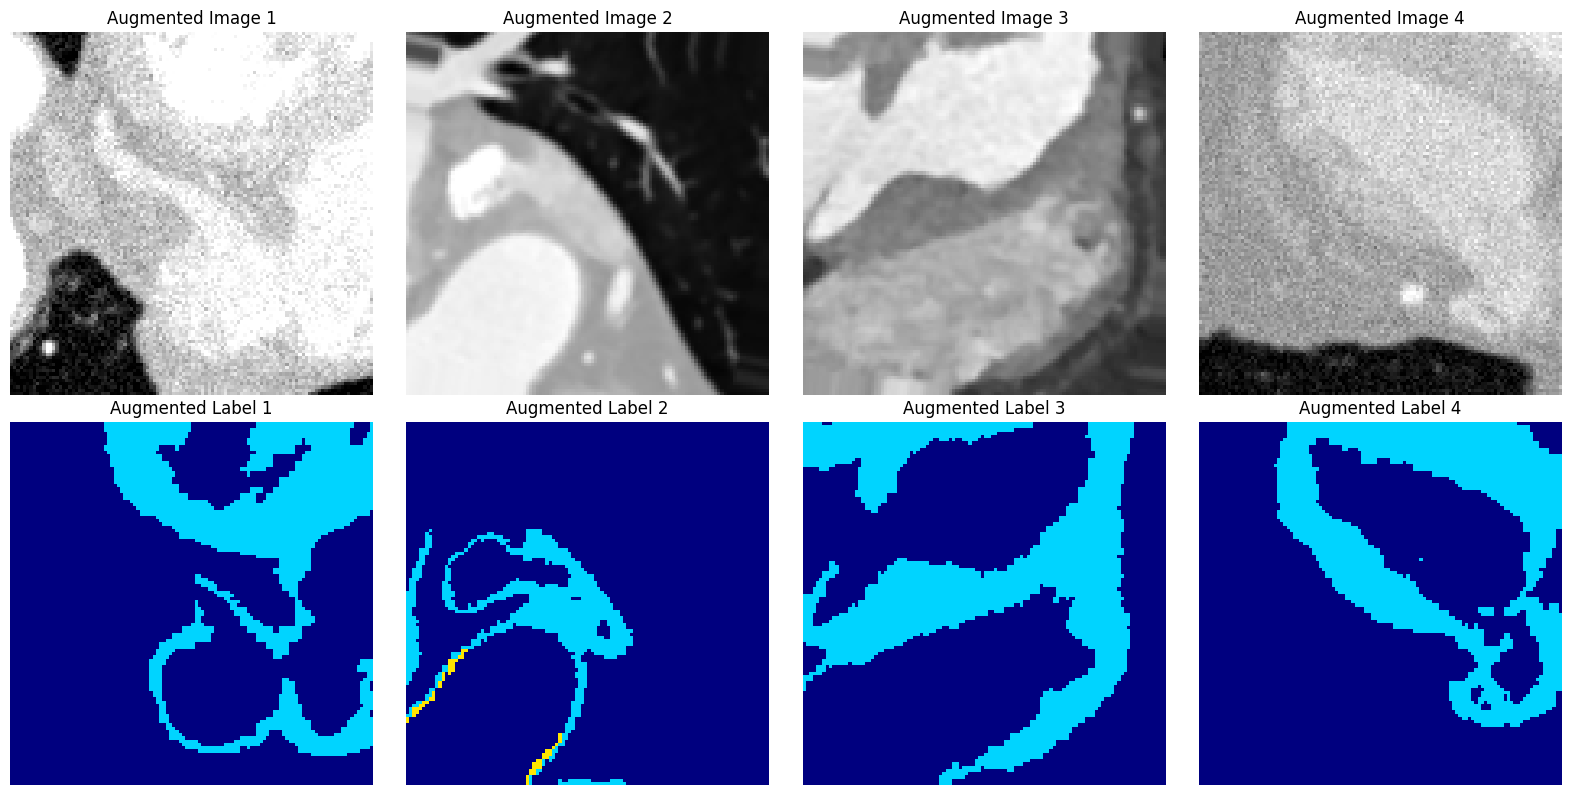


影像形狀: torch.Size([1, 112, 112, 112])
標籤形狀: torch.Size([112, 112, 112])
標籤類別: tensor([0, 1, 2])


In [9]:
# 視覺化資料增強效果 - 同一張影像的多次增強結果
print('展示資料增強效果（同一張影像的 4 次不同增強）\n')

# 取得同一個索引的資料多次，每次都會套用不同的隨機增強
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # 每次呼叫都會產生不同的增強結果
    aug_image, aug_label = train_dataset[0]
    slice_idx = aug_image.shape[-1] // 2

    # 顯示增強後的影像
    axes[0, i].imshow(aug_image[0, :, :, slice_idx], cmap='gray')
    axes[0, i].set_title(f'Augmented Image {i+1}')
    axes[0, i].axis('off')

    # 顯示增強後的標籤
    axes[1, i].imshow(aug_label[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[1, i].set_title(f'Augmented Label {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# 顯示基本資訊
sample_image, sample_label = train_dataset[0]
print(f'\n影像形狀: {sample_image.shape}')
print(f'標籤形狀: {sample_label.shape}')
print(f'標籤類別: {torch.unique(sample_label)}')


## 8. 建立模型和訓練設定


In [10]:
# 建立模型
model = UNet3D(in_channels=1, num_classes=4, base_channels=32)  # 提升模型容量
model = model.to(device)

def convert_conv3d_to_resconv3d(old_state_dict):
    """
    將舊的 Conv3DBlock 權重轉換為新的 ResConv3DBlock 權重

    舊結構 (Conv3DBlock):
    - conv.0: Conv3d (in_channels -> out_channels)
    - conv.1: BatchNorm3d
    - conv.3: Conv3d (out_channels -> out_channels)
    - conv.4: BatchNorm3d

    新結構 (ResConv3DBlock):
    - conv1: Conv3d (in_channels -> out_channels)
    - bn1: BatchNorm3d
    - conv2: Conv3d (out_channels -> out_channels)
    - bn2: BatchNorm3d
    - residual_conv: Conv3d (in_channels -> out_channels) [如果 in_channels != out_channels]
    """
    new_state_dict = {}

    # 需要轉換的層名稱（encoder, bottleneck, decoder）
    block_names = ['enc1', 'enc2', 'enc3', 'enc4', 'bottleneck', 'dec4', 'dec3', 'dec2', 'dec1']

    for key, value in old_state_dict.items():
        # 檢查是否是需要轉換的 Conv3DBlock 層
        is_conv_block = False
        block_name = None

        for name in block_names:
            if key.startswith(f'{name}.conv.'):
                is_conv_block = True
                block_name = name
                break

        if is_conv_block:
            # 提取層索引（conv.0, conv.1, conv.3, conv.4）
            layer_idx = int(key.split('.')[-2])

            if layer_idx == 0:  # conv.0 -> conv1
                new_key = key.replace(f'{block_name}.conv.0', f'{block_name}.conv1')
            elif layer_idx == 1:  # conv.1 -> bn1
                new_key = key.replace(f'{block_name}.conv.1', f'{block_name}.bn1')
            elif layer_idx == 3:  # conv.3 -> conv2
                new_key = key.replace(f'{block_name}.conv.3', f'{block_name}.conv2')
            elif layer_idx == 4:  # conv.4 -> bn2
                new_key = key.replace(f'{block_name}.conv.4', f'{block_name}.bn2')
            else:
                # 其他層（如 ReLU）不需要轉換
                continue

            new_state_dict[new_key] = value
        else:
            # 非 Conv3DBlock 層直接複製
            new_state_dict[key] = value

    # 為 ResConv3DBlock 添加 residual_conv 權重（如果需要）
    # 對於 in_channels != out_channels 的情況，初始化 1x1x1 卷積
    for name in block_names:
        conv1_key = f'{name}.conv1.weight'
        residual_conv_key = f'{name}.residual_conv.weight'

        if conv1_key in new_state_dict and residual_conv_key not in new_state_dict:
            # 檢查是否需要 residual_conv（通過比較 conv1 的輸入輸出通道數）
            conv1_weight = new_state_dict[conv1_key]
            in_channels = conv1_weight.shape[1]
            out_channels = conv1_weight.shape[0]

            if in_channels != out_channels:
                # 初始化 residual_conv 為 1x1x1 卷積（不是 3x3x3）
                # 形狀為 (out_channels, in_channels, 1, 1, 1)
                # 確保在與其他權重相同的設備上
                device = conv1_weight.device
                residual_weight = torch.zeros(out_channels, in_channels, 1, 1, 1, device=device)
                # 使用 Xavier 初始化
                nn.init.xavier_uniform_(residual_weight)
                new_state_dict[residual_conv_key] = residual_weight

                # 初始化 bias
                residual_bias_key = f'{name}.residual_conv.bias'
                if residual_bias_key not in new_state_dict:
                    residual_bias = torch.zeros(out_channels, device=device)
                    new_state_dict[residual_bias_key] = residual_bias

    return new_state_dict

# 載入預訓練權重（log/20251120_ver6/checkpoints）
PRETRAINED_CHECKPOINT = '/content/gdrive/MyDrive/aicup_data/aicup_results/best_model_20251120-3.pth'
print(f'正在載入預訓練權重：{PRETRAINED_CHECKPOINT}')
pretrained_ckpt = torch.load(PRETRAINED_CHECKPOINT, map_location=device, weights_only=False)

# 檢查是否需要轉換權重（檢查是否有舊的 conv.0 格式）
old_state_dict = pretrained_ckpt['model_state_dict']
needs_conversion = any('conv.0' in key for key in old_state_dict.keys())

if needs_conversion:
    print('🔄 檢測到舊的 Conv3DBlock 權重格式，正在轉換為 ResConv3DBlock 格式...')
    converted_state_dict = convert_conv3d_to_resconv3d(old_state_dict)
    model.load_state_dict(converted_state_dict, strict=False)
    print('✅ 權重轉換完成！')
else:
    # 直接載入（已經是 ResConv3DBlock 格式）
    model.load_state_dict(old_state_dict, strict=False)

print('✅ 成功載入最佳模型權重！')
if 'val_score' in pretrained_ckpt:
    print(f"   來源模型 Score: {pretrained_ckpt['val_score']:.4f} (Dice {pretrained_ckpt.get('val_dice', 0):.4f}, IoU {pretrained_ckpt.get('val_iou', 0):.4f})")

# 計算模型參數量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'總參數量: {total_params:,}')
print(f'可訓練參數量: {trainable_params:,}')

# 損失函數和優化器
print('='*70)
print('🔧 訓練配置')
print('='*70)

criterion = CombinedLoss(num_classes=4, device=device)

# ⭐ 加入 L2 正則化 (Weight Decay)
WEIGHT_DECAY = 1e-4  # L2 正則化強度
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=WEIGHT_DECAY)  # ⭐ Learning Rate: 1e-4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)  # ⭐ patience=10

print(f'\n⚙️ 優化器配置：')
print(f'   - Optimizer: Adam')
print(f'   - Learning Rate: 1e-4')
print(f'   - Weight Decay (L2): {WEIGHT_DECAY} ⭐ 防止過擬合')
print(f'   - Scheduler: ReduceLROnPlateau (patience=10, factor=0.5) ⭐ 更有耐心')

# 訓練設定
NUM_EPOCHS = 150  # ⭐ 150 epochs
SAVE_DIR = 'checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)

print(f'\n📅 訓練設定：')
print(f'   - Epochs: {NUM_EPOCHS}')
print(f'   - Checkpoint 目錄: {SAVE_DIR}')
print('='*70 + '\n')



正在載入預訓練權重：/content/gdrive/MyDrive/aicup_data/aicup_results/best_model_20251120-3.pth
🔄 檢測到舊的 Conv3DBlock 權重格式，正在轉換為 ResConv3DBlock 格式...
✅ 權重轉換完成！
✅ 成功載入最佳模型權重！
   來源模型 Score: 0.7254 (Dice 0.7855, IoU 0.6653)
總參數量: 22,930,980
可訓練參數量: 22,930,980
🔧 訓練配置
🎯 使用預設類別權重：
   - 背景 (class 0): 0.5
   - 心臟組織 (class 1-3): 1.5

📊 損失函數配置：
   CrossEntropy: 40.0% (含類別權重 ⭐)
   Dice Loss: 30.0%
   Boundary Loss: 30.0%

⚙️ 優化器配置：
   - Optimizer: Adam
   - Learning Rate: 1e-4
   - Weight Decay (L2): 0.0001 ⭐ 防止過擬合
   - Scheduler: ReduceLROnPlateau (patience=10, factor=0.5) ⭐ 更有耐心

📅 訓練設定：
   - Epochs: 150
   - Checkpoint 目錄: checkpoints



## 9. 訓練函數


In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    """訓練一個 epoch"""
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_score = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # 計算評估指標
        dice = dice_coefficient(outputs, labels)
        iou = iou_coefficient(outputs, labels)
        score = combined_score(outputs, labels)

        total_loss += loss.item()
        total_dice += dice
        total_iou += iou
        total_score += score

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}',
            'score': f'{score:.4f}'
        })

    return (total_loss / len(loader),
            total_dice / len(loader),
            total_iou / len(loader),
            total_score / len(loader))


def validate_epoch(model, loader, criterion, device):
    """驗證一個 epoch"""
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_score = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # 計算評估指標
            dice = dice_coefficient(outputs, labels)
            iou = iou_coefficient(outputs, labels)
            score = combined_score(outputs, labels)

            total_loss += loss.item()
            total_dice += dice
            total_iou += iou
            total_score += score

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'score': f'{score:.4f}'
            })

    return (total_loss / len(loader),
            total_dice / len(loader),
            total_iou / len(loader),
            total_score / len(loader))


In [12]:
# 訓練歷史
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'train_score': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'val_score': []
}

best_val_score = 0.0  # 使用 Combined Score 選擇最佳模型

print('開始訓練...\\n')
print('📊 評分標準：Combined Score = (Dice + IoU) / 2')
print('='*60 + '\\n')

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 60)

    # 訓練
    train_loss, train_dice, train_iou, train_score = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # 驗證
    val_loss, val_dice, val_iou, val_score = validate_epoch(
        model, val_loader, criterion, device
    )

    # 更新學習率
    scheduler.step(val_loss)

    # 記錄歷史
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['train_score'].append(train_score)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['val_score'].append(val_score)

    # 顯示結果
    print(f'\\n📈 Training:')
    print(f'   Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f} | Score: {train_score:.4f}')
    print(f'📊 Validation:')
    print(f'   Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | Score: {val_score:.4f}')
    print(f'🔧 Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\\n')

    # 儲存最佳模型（使用 Combined Score）
    if val_score > best_val_score:
        best_val_score = val_score
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'val_iou': val_iou,
            'val_score': val_score,
        }, os.path.join(SAVE_DIR, 'best_model.pth'))
        print(f'✅ 儲存最佳模型！')
        print(f'   Combined Score: {val_score:.4f} (Dice: {val_dice:.4f}, IoU: {val_iou:.4f})\\n')

    # 定期儲存檢查點
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'val_iou': val_iou,
            'val_score': val_score,
        }, os.path.join(SAVE_DIR, f'checkpoint_epoch_{epoch+1}.pth'))

print('='*60)
print('🎉 訓練完成！')
print(f'🏆 最佳 Combined Score: {best_val_score:.4f}')
print('='*60)


開始訓練...\n
📊 評分標準：Combined Score = (Dice + IoU) / 2
============================================================\n
Epoch 1/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, loss=0.2190, dice=0.6374, iou=0.5182, score=0.5778]


\n📈 Training:
   Loss: 0.2119 | Dice: 0.6681 | IoU: 0.5490 | Score: 0.6086
📊 Validation:
   Loss: 0.2120 | Dice: 0.6515 | IoU: 0.5288 | Score: 0.5901
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.5901 (Dice: 0.6515, IoU: 0.5288)\n
Epoch 2/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s, loss=0.2257, dice=0.7943, iou=0.6651, score=0.7297]


\n📈 Training:
   Loss: 0.1907 | Dice: 0.7000 | IoU: 0.5846 | Score: 0.6423
📊 Validation:
   Loss: 0.2148 | Dice: 0.7270 | IoU: 0.6082 | Score: 0.6676
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6676 (Dice: 0.7270, IoU: 0.6082)\n
Epoch 3/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.2040, dice=0.4228, iou=0.3662, score=0.3945]


\n📈 Training:
   Loss: 0.1985 | Dice: 0.6950 | IoU: 0.5786 | Score: 0.6368
📊 Validation:
   Loss: 0.1936 | Dice: 0.7100 | IoU: 0.5927 | Score: 0.6514
🔧 Learning Rate: 0.000100\n
Epoch 4/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1893, dice=0.7353, iou=0.5952, score=0.6652]


\n📈 Training:
   Loss: 0.1885 | Dice: 0.6817 | IoU: 0.5710 | Score: 0.6263
📊 Validation:
   Loss: 0.2021 | Dice: 0.6838 | IoU: 0.5710 | Score: 0.6274
🔧 Learning Rate: 0.000100\n
Epoch 5/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss=0.1642, dice=0.7840, iou=0.6628, score=0.7234]


\n📈 Training:
   Loss: 0.1806 | Dice: 0.6774 | IoU: 0.5708 | Score: 0.6241
📊 Validation:
   Loss: 0.1898 | Dice: 0.7306 | IoU: 0.6134 | Score: 0.6720
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6720 (Dice: 0.7306, IoU: 0.6134)\n
Epoch 6/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s, loss=0.1757, dice=0.7764, iou=0.6435, score=0.7100]


\n📈 Training:
   Loss: 0.1757 | Dice: 0.7458 | IoU: 0.6333 | Score: 0.6895
📊 Validation:
   Loss: 0.1896 | Dice: 0.7286 | IoU: 0.6093 | Score: 0.6690
🔧 Learning Rate: 0.000100\n
Epoch 7/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s, loss=0.2303, dice=0.5222, iou=0.3717, score=0.4470]


\n📈 Training:
   Loss: 0.1846 | Dice: 0.6955 | IoU: 0.5861 | Score: 0.6408
📊 Validation:
   Loss: 0.2034 | Dice: 0.6828 | IoU: 0.5601 | Score: 0.6215
🔧 Learning Rate: 0.000100\n
Epoch 8/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, loss=0.1665, dice=0.7857, iou=0.6635, score=0.7246]


\n📈 Training:
   Loss: 0.1783 | Dice: 0.7137 | IoU: 0.6032 | Score: 0.6584
📊 Validation:
   Loss: 0.1955 | Dice: 0.7343 | IoU: 0.6123 | Score: 0.6733
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6733 (Dice: 0.7343, IoU: 0.6123)\n
Epoch 9/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss=0.1744, dice=0.7202, iou=0.5816, score=0.6509]


\n📈 Training:
   Loss: 0.1785 | Dice: 0.7025 | IoU: 0.5918 | Score: 0.6471
📊 Validation:
   Loss: 0.1839 | Dice: 0.7284 | IoU: 0.6136 | Score: 0.6710
🔧 Learning Rate: 0.000100\n
Epoch 10/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, loss=0.1960, dice=0.8015, iou=0.6784, score=0.7399]


\n📈 Training:
   Loss: 0.1786 | Dice: 0.7271 | IoU: 0.6143 | Score: 0.6707
📊 Validation:
   Loss: 0.2034 | Dice: 0.7026 | IoU: 0.5814 | Score: 0.6420
🔧 Learning Rate: 0.000100\n
Epoch 11/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, loss=0.1817, dice=0.7922, iou=0.6668, score=0.7295]


\n📈 Training:
   Loss: 0.1798 | Dice: 0.7240 | IoU: 0.6105 | Score: 0.6672
📊 Validation:
   Loss: 0.1967 | Dice: 0.7215 | IoU: 0.6042 | Score: 0.6629
🔧 Learning Rate: 0.000100\n
Epoch 12/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, loss=0.1796, dice=0.8112, iou=0.6937, score=0.7524]


\n📈 Training:
   Loss: 0.1785 | Dice: 0.7022 | IoU: 0.5939 | Score: 0.6480
📊 Validation:
   Loss: 0.1853 | Dice: 0.7346 | IoU: 0.6223 | Score: 0.6784
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6784 (Dice: 0.7346, IoU: 0.6223)\n
Epoch 13/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, loss=0.1971, dice=0.7846, iou=0.6514, score=0.7180]


\n📈 Training:
   Loss: 0.1753 | Dice: 0.7115 | IoU: 0.6022 | Score: 0.6568
📊 Validation:
   Loss: 0.1945 | Dice: 0.7267 | IoU: 0.6173 | Score: 0.6720
🔧 Learning Rate: 0.000100\n
Epoch 14/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, loss=0.1924, dice=0.7477, iou=0.6007, score=0.6742]


\n📈 Training:
   Loss: 0.1827 | Dice: 0.7092 | IoU: 0.5973 | Score: 0.6533
📊 Validation:
   Loss: 0.1958 | Dice: 0.7430 | IoU: 0.6166 | Score: 0.6798
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6798 (Dice: 0.7430, IoU: 0.6166)\n
Epoch 15/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, loss=0.2184, dice=0.7968, iou=0.6713, score=0.7341]


\n📈 Training:
   Loss: 0.1810 | Dice: 0.7160 | IoU: 0.6046 | Score: 0.6603
📊 Validation:
   Loss: 0.2203 | Dice: 0.6722 | IoU: 0.5518 | Score: 0.6120
🔧 Learning Rate: 0.000100\n
Epoch 16/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, loss=0.1964, dice=0.7680, iou=0.6313, score=0.6997]


\n📈 Training:
   Loss: 0.1728 | Dice: 0.7236 | IoU: 0.6149 | Score: 0.6693
📊 Validation:
   Loss: 0.1886 | Dice: 0.7033 | IoU: 0.5852 | Score: 0.6442
🔧 Learning Rate: 0.000100\n
Epoch 17/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, loss=0.2213, dice=0.7744, iou=0.6354, score=0.7049]


\n📈 Training:
   Loss: 0.1756 | Dice: 0.7181 | IoU: 0.6109 | Score: 0.6645
📊 Validation:
   Loss: 0.1966 | Dice: 0.7386 | IoU: 0.6245 | Score: 0.6816
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6816 (Dice: 0.7386, IoU: 0.6245)\n
Epoch 18/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, loss=0.1869, dice=0.8092, iou=0.6883, score=0.7487]


\n📈 Training:
   Loss: 0.1825 | Dice: 0.7178 | IoU: 0.6087 | Score: 0.6633
📊 Validation:
   Loss: 0.1817 | Dice: 0.7197 | IoU: 0.6073 | Score: 0.6635
🔧 Learning Rate: 0.000100\n
Epoch 19/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, loss=0.1944, dice=0.7986, iou=0.6706, score=0.7346]


\n📈 Training:
   Loss: 0.1738 | Dice: 0.7338 | IoU: 0.6255 | Score: 0.6797
📊 Validation:
   Loss: 0.1949 | Dice: 0.7349 | IoU: 0.6107 | Score: 0.6728
🔧 Learning Rate: 0.000100\n
Epoch 20/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, loss=0.1979, dice=0.8161, iou=0.6980, score=0.7571]


\n📈 Training:
   Loss: 0.1721 | Dice: 0.7401 | IoU: 0.6305 | Score: 0.6853
📊 Validation:
   Loss: 0.1821 | Dice: 0.7142 | IoU: 0.6012 | Score: 0.6577
🔧 Learning Rate: 0.000100\n
Epoch 21/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, loss=0.2148, dice=0.7573, iou=0.6156, score=0.6865]


\n📈 Training:
   Loss: 0.1753 | Dice: 0.7158 | IoU: 0.6089 | Score: 0.6624
📊 Validation:
   Loss: 0.1823 | Dice: 0.7457 | IoU: 0.6310 | Score: 0.6883
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6883 (Dice: 0.7457, IoU: 0.6310)\n
Epoch 22/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.49it/s, loss=0.1999, dice=0.7997, iou=0.6700, score=0.7348]


\n📈 Training:
   Loss: 0.1685 | Dice: 0.7412 | IoU: 0.6321 | Score: 0.6866
📊 Validation:
   Loss: 0.1930 | Dice: 0.6873 | IoU: 0.5821 | Score: 0.6347
🔧 Learning Rate: 0.000100\n
Epoch 23/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, loss=0.2347, dice=0.7365, iou=0.5961, score=0.6663]


\n📈 Training:
   Loss: 0.1792 | Dice: 0.7182 | IoU: 0.6072 | Score: 0.6627
📊 Validation:
   Loss: 0.2151 | Dice: 0.6687 | IoU: 0.5371 | Score: 0.6029
🔧 Learning Rate: 0.000100\n
Epoch 24/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s, loss=0.2167, dice=0.8026, iou=0.6777, score=0.7402]


\n📈 Training:
   Loss: 0.1765 | Dice: 0.7099 | IoU: 0.5994 | Score: 0.6547
📊 Validation:
   Loss: 0.1861 | Dice: 0.7365 | IoU: 0.6195 | Score: 0.6780
🔧 Learning Rate: 0.000100\n
Epoch 25/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, loss=0.2391, dice=0.7412, iou=0.6091, score=0.6751]


\n📈 Training:
   Loss: 0.1742 | Dice: 0.7342 | IoU: 0.6220 | Score: 0.6781
📊 Validation:
   Loss: 0.2048 | Dice: 0.6784 | IoU: 0.5566 | Score: 0.6175
🔧 Learning Rate: 0.000100\n
Epoch 26/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.50it/s, loss=0.2050, dice=0.7065, iou=0.5661, score=0.6363]


\n📈 Training:
   Loss: 0.1838 | Dice: 0.7052 | IoU: 0.5956 | Score: 0.6504
📊 Validation:
   Loss: 0.2184 | Dice: 0.6758 | IoU: 0.5506 | Score: 0.6132
🔧 Learning Rate: 0.000100\n
Epoch 27/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s, loss=0.1608, dice=0.8229, iou=0.7070, score=0.7650]


\n📈 Training:
   Loss: 0.1789 | Dice: 0.7136 | IoU: 0.6043 | Score: 0.6590
📊 Validation:
   Loss: 0.1927 | Dice: 0.7494 | IoU: 0.6400 | Score: 0.6947
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6947 (Dice: 0.7494, IoU: 0.6400)\n
Epoch 28/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, loss=0.1891, dice=0.8195, iou=0.7035, score=0.7615]


\n📈 Training:
   Loss: 0.1728 | Dice: 0.7085 | IoU: 0.6060 | Score: 0.6572
📊 Validation:
   Loss: 0.1865 | Dice: 0.7276 | IoU: 0.6148 | Score: 0.6712
🔧 Learning Rate: 0.000100\n
Epoch 29/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, loss=0.3240, dice=0.6596, iou=0.4931, score=0.5764]


\n📈 Training:
   Loss: 0.1895 | Dice: 0.7017 | IoU: 0.5907 | Score: 0.6462
📊 Validation:
   Loss: 0.2617 | Dice: 0.6300 | IoU: 0.4836 | Score: 0.5568
🔧 Learning Rate: 0.000050\n
Epoch 30/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, loss=0.1780, dice=0.8203, iou=0.7042, score=0.7622]


\n📈 Training:
   Loss: 0.1846 | Dice: 0.7148 | IoU: 0.6025 | Score: 0.6586
📊 Validation:
   Loss: 0.1965 | Dice: 0.7430 | IoU: 0.6292 | Score: 0.6861
🔧 Learning Rate: 0.000050\n
Epoch 31/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, loss=0.1804, dice=0.7487, iou=0.6100, score=0.6794]


\n📈 Training:
   Loss: 0.1764 | Dice: 0.7084 | IoU: 0.6031 | Score: 0.6558
📊 Validation:
   Loss: 0.1861 | Dice: 0.7427 | IoU: 0.6295 | Score: 0.6861
🔧 Learning Rate: 0.000050\n
Epoch 32/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s, loss=0.1814, dice=0.8044, iou=0.6838, score=0.7441]


\n📈 Training:
   Loss: 0.1700 | Dice: 0.6943 | IoU: 0.5954 | Score: 0.6449
📊 Validation:
   Loss: 0.1841 | Dice: 0.7124 | IoU: 0.6010 | Score: 0.6567
🔧 Learning Rate: 0.000050\n
Epoch 33/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, loss=0.1749, dice=0.8227, iou=0.7083, score=0.7655]


\n📈 Training:
   Loss: 0.1659 | Dice: 0.7276 | IoU: 0.6240 | Score: 0.6758
📊 Validation:
   Loss: 0.1711 | Dice: 0.7435 | IoU: 0.6300 | Score: 0.6867
🔧 Learning Rate: 0.000050\n
Epoch 34/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, loss=0.1780, dice=0.7384, iou=0.5873, score=0.6628]


\n📈 Training:
   Loss: 0.1681 | Dice: 0.7482 | IoU: 0.6416 | Score: 0.6949
📊 Validation:
   Loss: 0.1819 | Dice: 0.7383 | IoU: 0.6237 | Score: 0.6810
🔧 Learning Rate: 0.000050\n
Epoch 35/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, loss=0.1831, dice=0.8209, iou=0.7042, score=0.7625]


\n📈 Training:
   Loss: 0.1647 | Dice: 0.7532 | IoU: 0.6453 | Score: 0.6992
📊 Validation:
   Loss: 0.1746 | Dice: 0.7429 | IoU: 0.6299 | Score: 0.6864
🔧 Learning Rate: 0.000050\n
Epoch 36/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, loss=0.1586, dice=0.8336, iou=0.7225, score=0.7781]


\n📈 Training:
   Loss: 0.1647 | Dice: 0.7727 | IoU: 0.6646 | Score: 0.7186
📊 Validation:
   Loss: 0.1675 | Dice: 0.7574 | IoU: 0.6510 | Score: 0.7042
🔧 Learning Rate: 0.000050\n
✅ 儲存最佳模型！
   Combined Score: 0.7042 (Dice: 0.7574, IoU: 0.6510)\n
Epoch 37/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, loss=0.1622, dice=0.8242, iou=0.7125, score=0.7684]


\n📈 Training:
   Loss: 0.1665 | Dice: 0.7388 | IoU: 0.6352 | Score: 0.6870
📊 Validation:
   Loss: 0.1861 | Dice: 0.7381 | IoU: 0.6250 | Score: 0.6816
🔧 Learning Rate: 0.000050\n
Epoch 38/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.1797, dice=0.7734, iou=0.6414, score=0.7074]


\n📈 Training:
   Loss: 0.1652 | Dice: 0.7354 | IoU: 0.6362 | Score: 0.6858
📊 Validation:
   Loss: 0.1788 | Dice: 0.7736 | IoU: 0.6569 | Score: 0.7152
🔧 Learning Rate: 0.000050\n
✅ 儲存最佳模型！
   Combined Score: 0.7152 (Dice: 0.7736, IoU: 0.6569)\n
Epoch 39/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.2131, dice=0.8063, iou=0.6824, score=0.7443]


\n📈 Training:
   Loss: 0.1716 | Dice: 0.7177 | IoU: 0.6152 | Score: 0.6665
📊 Validation:
   Loss: 0.1815 | Dice: 0.7407 | IoU: 0.6272 | Score: 0.6839
🔧 Learning Rate: 0.000050\n
Epoch 40/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s, loss=0.1639, dice=0.8374, iou=0.7310, score=0.7842]


\n📈 Training:
   Loss: 0.1679 | Dice: 0.7079 | IoU: 0.6073 | Score: 0.6576
📊 Validation:
   Loss: 0.1843 | Dice: 0.7691 | IoU: 0.6536 | Score: 0.7114
🔧 Learning Rate: 0.000050\n
Epoch 41/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, loss=0.1824, dice=0.8156, iou=0.7004, score=0.7580]


\n📈 Training:
   Loss: 0.1654 | Dice: 0.7409 | IoU: 0.6365 | Score: 0.6887
📊 Validation:
   Loss: 0.1886 | Dice: 0.7469 | IoU: 0.6362 | Score: 0.6915
🔧 Learning Rate: 0.000050\n
Epoch 42/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, loss=0.1979, dice=0.8150, iou=0.6975, score=0.7563]


\n📈 Training:
   Loss: 0.1636 | Dice: 0.7492 | IoU: 0.6469 | Score: 0.6980
📊 Validation:
   Loss: 0.1845 | Dice: 0.7344 | IoU: 0.6194 | Score: 0.6769
🔧 Learning Rate: 0.000050\n
Epoch 43/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s, loss=0.1717, dice=0.8215, iou=0.7051, score=0.7633]


\n📈 Training:
   Loss: 0.1653 | Dice: 0.7494 | IoU: 0.6400 | Score: 0.6947
📊 Validation:
   Loss: 0.1841 | Dice: 0.7280 | IoU: 0.6153 | Score: 0.6717
🔧 Learning Rate: 0.000050\n
Epoch 44/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, loss=0.1980, dice=0.8076, iou=0.6865, score=0.7470]


\n📈 Training:
   Loss: 0.1640 | Dice: 0.7355 | IoU: 0.6320 | Score: 0.6838
📊 Validation:
   Loss: 0.1949 | Dice: 0.7250 | IoU: 0.6082 | Score: 0.6666
🔧 Learning Rate: 0.000050\n
Epoch 45/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, loss=0.1949, dice=0.7942, iou=0.6642, score=0.7292]


\n📈 Training:
   Loss: 0.1682 | Dice: 0.7419 | IoU: 0.6356 | Score: 0.6887
📊 Validation:
   Loss: 0.1857 | Dice: 0.7236 | IoU: 0.6115 | Score: 0.6676
🔧 Learning Rate: 0.000050\n
Epoch 46/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, loss=0.1754, dice=0.8195, iou=0.7081, score=0.7638]


\n📈 Training:
   Loss: 0.1625 | Dice: 0.7347 | IoU: 0.6354 | Score: 0.6850
📊 Validation:
   Loss: 0.1864 | Dice: 0.7504 | IoU: 0.6402 | Score: 0.6953
🔧 Learning Rate: 0.000050\n
Epoch 47/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, loss=0.1795, dice=0.7959, iou=0.6667, score=0.7313]


\n📈 Training:
   Loss: 0.1647 | Dice: 0.7647 | IoU: 0.6579 | Score: 0.7113
📊 Validation:
   Loss: 0.1864 | Dice: 0.7377 | IoU: 0.6247 | Score: 0.6812
🔧 Learning Rate: 0.000025\n
Epoch 48/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, loss=0.1842, dice=0.8084, iou=0.6866, score=0.7475]


\n📈 Training:
   Loss: 0.1660 | Dice: 0.7169 | IoU: 0.6161 | Score: 0.6665
📊 Validation:
   Loss: 0.1785 | Dice: 0.7509 | IoU: 0.6410 | Score: 0.6959
🔧 Learning Rate: 0.000025\n
Epoch 49/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, loss=0.1669, dice=0.8235, iou=0.7106, score=0.7670]


\n📈 Training:
   Loss: 0.1623 | Dice: 0.7454 | IoU: 0.6440 | Score: 0.6947
📊 Validation:
   Loss: 0.1906 | Dice: 0.7712 | IoU: 0.6537 | Score: 0.7124
🔧 Learning Rate: 0.000025\n
Epoch 50/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, loss=0.1603, dice=0.8219, iou=0.7045, score=0.7632]


\n📈 Training:
   Loss: 0.1660 | Dice: 0.7318 | IoU: 0.6290 | Score: 0.6804
📊 Validation:
   Loss: 0.1968 | Dice: 0.7132 | IoU: 0.5923 | Score: 0.6528
🔧 Learning Rate: 0.000025\n
Epoch 51/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s, loss=0.1780, dice=0.7875, iou=0.6543, score=0.7209]


\n📈 Training:
   Loss: 0.1606 | Dice: 0.7313 | IoU: 0.6316 | Score: 0.6814
📊 Validation:
   Loss: 0.1880 | Dice: 0.7442 | IoU: 0.6317 | Score: 0.6879
🔧 Learning Rate: 0.000025\n
Epoch 52/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s, loss=0.1509, dice=0.8422, iou=0.7393, score=0.7907]


\n📈 Training:
   Loss: 0.1619 | Dice: 0.7352 | IoU: 0.6341 | Score: 0.6846
📊 Validation:
   Loss: 0.1765 | Dice: 0.7383 | IoU: 0.6246 | Score: 0.6814
🔧 Learning Rate: 0.000025\n
Epoch 53/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, loss=0.1645, dice=0.8172, iou=0.7027, score=0.7599]


\n📈 Training:
   Loss: 0.1621 | Dice: 0.7185 | IoU: 0.6176 | Score: 0.6681
📊 Validation:
   Loss: 0.1828 | Dice: 0.7316 | IoU: 0.6203 | Score: 0.6759
🔧 Learning Rate: 0.000025\n
Epoch 54/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, loss=0.1767, dice=0.8228, iou=0.7074, score=0.7651]


\n📈 Training:
   Loss: 0.1614 | Dice: 0.7367 | IoU: 0.6359 | Score: 0.6863
📊 Validation:
   Loss: 0.1824 | Dice: 0.7762 | IoU: 0.6615 | Score: 0.7188
🔧 Learning Rate: 0.000025\n
✅ 儲存最佳模型！
   Combined Score: 0.7188 (Dice: 0.7762, IoU: 0.6615)\n
Epoch 55/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss=0.1433, dice=0.8488, iou=0.7493, score=0.7990]


\n📈 Training:
   Loss: 0.1582 | Dice: 0.7474 | IoU: 0.6487 | Score: 0.6980
📊 Validation:
   Loss: 0.1697 | Dice: 0.7730 | IoU: 0.6605 | Score: 0.7167
🔧 Learning Rate: 0.000025\n
Epoch 56/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s, loss=0.1317, dice=0.8529, iou=0.7553, score=0.8041]


\n📈 Training:
   Loss: 0.1600 | Dice: 0.7329 | IoU: 0.6318 | Score: 0.6823
📊 Validation:
   Loss: 0.1664 | Dice: 0.7639 | IoU: 0.6592 | Score: 0.7116
🔧 Learning Rate: 0.000025\n
Epoch 57/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, loss=0.1465, dice=0.8487, iou=0.7496, score=0.7991]


\n📈 Training:
   Loss: 0.1607 | Dice: 0.7660 | IoU: 0.6618 | Score: 0.7139
📊 Validation:
   Loss: 0.1775 | Dice: 0.7428 | IoU: 0.6320 | Score: 0.6874
🔧 Learning Rate: 0.000025\n
Epoch 58/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, loss=0.1647, dice=0.8303, iou=0.7211, score=0.7757]


\n📈 Training:
   Loss: 0.1586 | Dice: 0.7627 | IoU: 0.6611 | Score: 0.7119
📊 Validation:
   Loss: 0.1683 | Dice: 0.7382 | IoU: 0.6293 | Score: 0.6837
🔧 Learning Rate: 0.000025\n
Epoch 59/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1853, dice=0.8100, iou=0.6972, score=0.7536]


\n📈 Training:
   Loss: 0.1608 | Dice: 0.7337 | IoU: 0.6352 | Score: 0.6844
📊 Validation:
   Loss: 0.1908 | Dice: 0.7294 | IoU: 0.6125 | Score: 0.6709
🔧 Learning Rate: 0.000025\n
Epoch 60/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, loss=0.2352, dice=0.7930, iou=0.6598, score=0.7264]


\n📈 Training:
   Loss: 0.1537 | Dice: 0.7453 | IoU: 0.6481 | Score: 0.6967
📊 Validation:
   Loss: 0.1894 | Dice: 0.7306 | IoU: 0.6153 | Score: 0.6730
🔧 Learning Rate: 0.000025\n
Epoch 61/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s, loss=0.1699, dice=0.8218, iou=0.7035, score=0.7627]


\n📈 Training:
   Loss: 0.1605 | Dice: 0.7415 | IoU: 0.6435 | Score: 0.6925
📊 Validation:
   Loss: 0.1783 | Dice: 0.7496 | IoU: 0.6410 | Score: 0.6953
🔧 Learning Rate: 0.000025\n
Epoch 62/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s, loss=0.1733, dice=0.8240, iou=0.7071, score=0.7656]


\n📈 Training:
   Loss: 0.1603 | Dice: 0.7551 | IoU: 0.6513 | Score: 0.7032
📊 Validation:
   Loss: 0.1792 | Dice: 0.7469 | IoU: 0.6343 | Score: 0.6906
🔧 Learning Rate: 0.000025\n
Epoch 63/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s, loss=0.1761, dice=0.8153, iou=0.6938, score=0.7546]


\n📈 Training:
   Loss: 0.1603 | Dice: 0.7439 | IoU: 0.6421 | Score: 0.6930
📊 Validation:
   Loss: 0.1939 | Dice: 0.7434 | IoU: 0.6293 | Score: 0.6863
🔧 Learning Rate: 0.000025\n
Epoch 64/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s, loss=0.1889, dice=0.8243, iou=0.7067, score=0.7655]


\n📈 Training:
   Loss: 0.1594 | Dice: 0.7315 | IoU: 0.6324 | Score: 0.6820
📊 Validation:
   Loss: 0.1904 | Dice: 0.6886 | IoU: 0.5811 | Score: 0.6348
🔧 Learning Rate: 0.000025\n
Epoch 65/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, loss=0.1585, dice=0.8242, iou=0.7077, score=0.7659]


\n📈 Training:
   Loss: 0.1582 | Dice: 0.7626 | IoU: 0.6634 | Score: 0.7130
📊 Validation:
   Loss: 0.1662 | Dice: 0.7765 | IoU: 0.6644 | Score: 0.7205
🔧 Learning Rate: 0.000025\n
✅ 儲存最佳模型！
   Combined Score: 0.7205 (Dice: 0.7765, IoU: 0.6644)\n
Epoch 66/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1868, dice=0.7971, iou=0.6653, score=0.7312]


\n📈 Training:
   Loss: 0.1634 | Dice: 0.7145 | IoU: 0.6186 | Score: 0.6666
📊 Validation:
   Loss: 0.1778 | Dice: 0.7617 | IoU: 0.6449 | Score: 0.7033
🔧 Learning Rate: 0.000025\n
Epoch 67/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s, loss=0.1862, dice=0.8098, iou=0.6835, score=0.7467]


\n📈 Training:
   Loss: 0.1606 | Dice: 0.7451 | IoU: 0.6442 | Score: 0.6946
📊 Validation:
   Loss: 0.1873 | Dice: 0.7511 | IoU: 0.6412 | Score: 0.6961
🔧 Learning Rate: 0.000025\n
Epoch 68/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, loss=0.1858, dice=0.8258, iou=0.7102, score=0.7680]


\n📈 Training:
   Loss: 0.1602 | Dice: 0.7476 | IoU: 0.6440 | Score: 0.6958
📊 Validation:
   Loss: 0.1804 | Dice: 0.7516 | IoU: 0.6437 | Score: 0.6976
🔧 Learning Rate: 0.000025\n
Epoch 69/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, loss=0.1677, dice=0.8078, iou=0.6839, score=0.7458]


\n📈 Training:
   Loss: 0.1598 | Dice: 0.6969 | IoU: 0.6025 | Score: 0.6497
📊 Validation:
   Loss: 0.1744 | Dice: 0.7391 | IoU: 0.6269 | Score: 0.6830
🔧 Learning Rate: 0.000025\n
Epoch 70/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, loss=0.1453, dice=0.8339, iou=0.7234, score=0.7786]


\n📈 Training:
   Loss: 0.1646 | Dice: 0.7432 | IoU: 0.6447 | Score: 0.6939
📊 Validation:
   Loss: 0.1813 | Dice: 0.7446 | IoU: 0.6333 | Score: 0.6889
🔧 Learning Rate: 0.000025\n
Epoch 71/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, loss=0.1729, dice=0.8300, iou=0.7191, score=0.7745]


\n📈 Training:
   Loss: 0.1583 | Dice: 0.7476 | IoU: 0.6497 | Score: 0.6987
📊 Validation:
   Loss: 0.1771 | Dice: 0.7350 | IoU: 0.6213 | Score: 0.6781
🔧 Learning Rate: 0.000025\n
Epoch 72/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, loss=0.1868, dice=0.8006, iou=0.6710, score=0.7358]


\n📈 Training:
   Loss: 0.1624 | Dice: 0.7509 | IoU: 0.6524 | Score: 0.7017
📊 Validation:
   Loss: 0.1806 | Dice: 0.7702 | IoU: 0.6582 | Score: 0.7142
🔧 Learning Rate: 0.000025\n
Epoch 73/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, loss=0.1848, dice=0.8206, iou=0.7032, score=0.7619]


\n📈 Training:
   Loss: 0.1583 | Dice: 0.7370 | IoU: 0.6398 | Score: 0.6884
📊 Validation:
   Loss: 0.1717 | Dice: 0.7480 | IoU: 0.6386 | Score: 0.6933
🔧 Learning Rate: 0.000025\n
Epoch 74/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.1637, dice=0.7995, iou=0.6778, score=0.7387]


\n📈 Training:
   Loss: 0.1563 | Dice: 0.7747 | IoU: 0.6716 | Score: 0.7232
📊 Validation:
   Loss: 0.1727 | Dice: 0.7450 | IoU: 0.6345 | Score: 0.6898
🔧 Learning Rate: 0.000025\n
Epoch 75/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.78it/s, loss=0.1686, dice=0.7909, iou=0.6709, score=0.7309]


\n📈 Training:
   Loss: 0.1606 | Dice: 0.7129 | IoU: 0.6170 | Score: 0.6649
📊 Validation:
   Loss: 0.1735 | Dice: 0.7539 | IoU: 0.6458 | Score: 0.6999
🔧 Learning Rate: 0.000025\n
Epoch 76/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s, loss=0.2067, dice=0.8099, iou=0.6855, score=0.7477]


\n📈 Training:
   Loss: 0.1612 | Dice: 0.7251 | IoU: 0.6266 | Score: 0.6759
📊 Validation:
   Loss: 0.1847 | Dice: 0.7475 | IoU: 0.6364 | Score: 0.6920
🔧 Learning Rate: 0.000013\n
Epoch 77/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, loss=0.1771, dice=0.8310, iou=0.7189, score=0.7749]


\n📈 Training:
   Loss: 0.1601 | Dice: 0.7494 | IoU: 0.6502 | Score: 0.6998
📊 Validation:
   Loss: 0.1847 | Dice: 0.7474 | IoU: 0.6362 | Score: 0.6918
🔧 Learning Rate: 0.000013\n
Epoch 78/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, loss=0.1637, dice=0.8166, iou=0.6959, score=0.7562]


\n📈 Training:
   Loss: 0.1573 | Dice: 0.7419 | IoU: 0.6445 | Score: 0.6932
📊 Validation:
   Loss: 0.1828 | Dice: 0.7467 | IoU: 0.6356 | Score: 0.6912
🔧 Learning Rate: 0.000013\n
Epoch 79/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, loss=0.1549, dice=0.8280, iou=0.7228, score=0.7754]


\n📈 Training:
   Loss: 0.1583 | Dice: 0.7599 | IoU: 0.6607 | Score: 0.7103
📊 Validation:
   Loss: 0.1711 | Dice: 0.7436 | IoU: 0.6333 | Score: 0.6884
🔧 Learning Rate: 0.000013\n
Epoch 80/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, loss=0.1508, dice=0.8246, iou=0.7081, score=0.7663]


\n📈 Training:
   Loss: 0.1552 | Dice: 0.7529 | IoU: 0.6553 | Score: 0.7041
📊 Validation:
   Loss: 0.1724 | Dice: 0.7363 | IoU: 0.6241 | Score: 0.6802
🔧 Learning Rate: 0.000013\n
Epoch 81/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss=0.2010, dice=0.8088, iou=0.6847, score=0.7468]


\n📈 Training:
   Loss: 0.1535 | Dice: 0.7710 | IoU: 0.6700 | Score: 0.7205
📊 Validation:
   Loss: 0.1887 | Dice: 0.7248 | IoU: 0.6145 | Score: 0.6696
🔧 Learning Rate: 0.000013\n
Epoch 82/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s, loss=0.1929, dice=0.8260, iou=0.7097, score=0.7678]


\n📈 Training:
   Loss: 0.1582 | Dice: 0.7197 | IoU: 0.6254 | Score: 0.6725
📊 Validation:
   Loss: 0.1700 | Dice: 0.7559 | IoU: 0.6483 | Score: 0.7021
🔧 Learning Rate: 0.000013\n
Epoch 83/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss=0.1711, dice=0.8187, iou=0.7002, score=0.7594]


\n📈 Training:
   Loss: 0.1589 | Dice: 0.7458 | IoU: 0.6484 | Score: 0.6971
📊 Validation:
   Loss: 0.1751 | Dice: 0.7758 | IoU: 0.6631 | Score: 0.7194
🔧 Learning Rate: 0.000013\n
Epoch 84/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s, loss=0.1703, dice=0.8067, iou=0.6870, score=0.7468]


\n📈 Training:
   Loss: 0.1608 | Dice: 0.7419 | IoU: 0.6435 | Score: 0.6927
📊 Validation:
   Loss: 0.1813 | Dice: 0.7358 | IoU: 0.6259 | Score: 0.6808
🔧 Learning Rate: 0.000013\n
Epoch 85/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, loss=0.1854, dice=0.8252, iou=0.7100, score=0.7676]


\n📈 Training:
   Loss: 0.1570 | Dice: 0.7342 | IoU: 0.6388 | Score: 0.6865
📊 Validation:
   Loss: 0.1675 | Dice: 0.7676 | IoU: 0.6558 | Score: 0.7117
🔧 Learning Rate: 0.000013\n
Epoch 86/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.2018, dice=0.8019, iou=0.6750, score=0.7385]


\n📈 Training:
   Loss: 0.1582 | Dice: 0.7322 | IoU: 0.6373 | Score: 0.6848
📊 Validation:
   Loss: 0.1915 | Dice: 0.7424 | IoU: 0.6303 | Score: 0.6864
🔧 Learning Rate: 0.000013\n
Epoch 87/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s, loss=0.1511, dice=0.8438, iou=0.7415, score=0.7926]


\n📈 Training:
   Loss: 0.1594 | Dice: 0.7383 | IoU: 0.6445 | Score: 0.6914
📊 Validation:
   Loss: 0.1793 | Dice: 0.7509 | IoU: 0.6399 | Score: 0.6954
🔧 Learning Rate: 0.000006\n
Epoch 88/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, loss=0.1933, dice=0.9356, iou=0.8791, score=0.9073]


\n📈 Training:
   Loss: 0.1543 | Dice: 0.7656 | IoU: 0.6681 | Score: 0.7168
📊 Validation:
   Loss: 0.1846 | Dice: 0.7678 | IoU: 0.6662 | Score: 0.7170
🔧 Learning Rate: 0.000006\n
Epoch 89/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s, loss=0.1932, dice=0.8228, iou=0.7058, score=0.7643]


\n📈 Training:
   Loss: 0.1555 | Dice: 0.7327 | IoU: 0.6388 | Score: 0.6857
📊 Validation:
   Loss: 0.1691 | Dice: 0.7562 | IoU: 0.6498 | Score: 0.7030
🔧 Learning Rate: 0.000006\n
Epoch 90/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1774, dice=0.7924, iou=0.6690, score=0.7307]


\n📈 Training:
   Loss: 0.1530 | Dice: 0.7373 | IoU: 0.6450 | Score: 0.6912
📊 Validation:
   Loss: 0.1689 | Dice: 0.7513 | IoU: 0.6453 | Score: 0.6983
🔧 Learning Rate: 0.000006\n
Epoch 91/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, loss=0.1428, dice=0.8117, iou=0.6994, score=0.7556]


\n📈 Training:
   Loss: 0.1553 | Dice: 0.7691 | IoU: 0.6703 | Score: 0.7197
📊 Validation:
   Loss: 0.1838 | Dice: 0.7600 | IoU: 0.6557 | Score: 0.7079
🔧 Learning Rate: 0.000006\n
Epoch 92/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, loss=0.1714, dice=0.8171, iou=0.6980, score=0.7576]


\n📈 Training:
   Loss: 0.1555 | Dice: 0.7355 | IoU: 0.6402 | Score: 0.6879
📊 Validation:
   Loss: 0.1727 | Dice: 0.7434 | IoU: 0.6325 | Score: 0.6879
🔧 Learning Rate: 0.000006\n
Epoch 93/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss=0.1985, dice=0.8340, iou=0.7237, score=0.7788]


\n📈 Training:
   Loss: 0.1548 | Dice: 0.7535 | IoU: 0.6555 | Score: 0.7045
📊 Validation:
   Loss: 0.1725 | Dice: 0.7501 | IoU: 0.6420 | Score: 0.6960
🔧 Learning Rate: 0.000006\n
Epoch 94/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss=0.1791, dice=0.8093, iou=0.6868, score=0.7481]


\n📈 Training:
   Loss: 0.1538 | Dice: 0.7493 | IoU: 0.6539 | Score: 0.7016
📊 Validation:
   Loss: 0.1681 | Dice: 0.7851 | IoU: 0.6772 | Score: 0.7311
🔧 Learning Rate: 0.000006\n
✅ 儲存最佳模型！
   Combined Score: 0.7311 (Dice: 0.7851, IoU: 0.6772)\n
Epoch 95/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s, loss=0.1976, dice=0.8088, iou=0.6835, score=0.7461]


\n📈 Training:
   Loss: 0.1561 | Dice: 0.7196 | IoU: 0.6269 | Score: 0.6733
📊 Validation:
   Loss: 0.1802 | Dice: 0.7418 | IoU: 0.6313 | Score: 0.6866
🔧 Learning Rate: 0.000006\n
Epoch 96/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s, loss=0.1684, dice=0.8088, iou=0.6887, score=0.7488]


\n📈 Training:
   Loss: 0.1555 | Dice: 0.7420 | IoU: 0.6434 | Score: 0.6927
📊 Validation:
   Loss: 0.1721 | Dice: 0.7534 | IoU: 0.6458 | Score: 0.6996
🔧 Learning Rate: 0.000006\n
Epoch 97/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s, loss=0.1716, dice=0.8360, iou=0.7265, score=0.7812]


\n📈 Training:
   Loss: 0.1541 | Dice: 0.7675 | IoU: 0.6683 | Score: 0.7179
📊 Validation:
   Loss: 0.1680 | Dice: 0.7513 | IoU: 0.6516 | Score: 0.7014
🔧 Learning Rate: 0.000006\n
Epoch 98/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s, loss=0.2065, dice=0.8299, iou=0.7161, score=0.7730]


\n📈 Training:
   Loss: 0.1574 | Dice: 0.7178 | IoU: 0.6255 | Score: 0.6716
📊 Validation:
   Loss: 0.1620 | Dice: 0.7973 | IoU: 0.6916 | Score: 0.7445
🔧 Learning Rate: 0.000006\n
✅ 儲存最佳模型！
   Combined Score: 0.7445 (Dice: 0.7973, IoU: 0.6916)\n
Epoch 99/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s, loss=0.1538, dice=0.8145, iou=0.7033, score=0.7589]


\n📈 Training:
   Loss: 0.1550 | Dice: 0.7321 | IoU: 0.6368 | Score: 0.6845
📊 Validation:
   Loss: 0.1692 | Dice: 0.7751 | IoU: 0.6632 | Score: 0.7192
🔧 Learning Rate: 0.000006\n
Epoch 100/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s, loss=0.1544, dice=0.8517, iou=0.7514, score=0.8016]


\n📈 Training:
   Loss: 0.1556 | Dice: 0.7190 | IoU: 0.6260 | Score: 0.6725
📊 Validation:
   Loss: 0.1925 | Dice: 0.7438 | IoU: 0.6313 | Score: 0.6876
🔧 Learning Rate: 0.000006\n
Epoch 101/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.1592, dice=0.8432, iou=0.7376, score=0.7904]


\n📈 Training:
   Loss: 0.1547 | Dice: 0.7805 | IoU: 0.6793 | Score: 0.7299
📊 Validation:
   Loss: 0.1692 | Dice: 0.8141 | IoU: 0.7044 | Score: 0.7593
🔧 Learning Rate: 0.000006\n
✅ 儲存最佳模型！
   Combined Score: 0.7593 (Dice: 0.8141, IoU: 0.7044)\n
Epoch 102/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss=0.1912, dice=0.8118, iou=0.6898, score=0.7508]


\n📈 Training:
   Loss: 0.1576 | Dice: 0.7354 | IoU: 0.6396 | Score: 0.6875
📊 Validation:
   Loss: 0.1848 | Dice: 0.7417 | IoU: 0.6295 | Score: 0.6856
🔧 Learning Rate: 0.000006\n
Epoch 103/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, loss=0.2041, dice=0.8305, iou=0.7185, score=0.7745]


\n📈 Training:
   Loss: 0.1556 | Dice: 0.7419 | IoU: 0.6477 | Score: 0.6948
📊 Validation:
   Loss: 0.1794 | Dice: 0.7338 | IoU: 0.6243 | Score: 0.6791
🔧 Learning Rate: 0.000006\n
Epoch 104/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1574, dice=0.8161, iou=0.6992, score=0.7577]


\n📈 Training:
   Loss: 0.1545 | Dice: 0.7461 | IoU: 0.6492 | Score: 0.6977
📊 Validation:
   Loss: 0.1780 | Dice: 0.7536 | IoU: 0.6466 | Score: 0.7001
🔧 Learning Rate: 0.000006\n
Epoch 105/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s, loss=0.1590, dice=0.8250, iou=0.7128, score=0.7689]


\n📈 Training:
   Loss: 0.1547 | Dice: 0.7679 | IoU: 0.6693 | Score: 0.7186
📊 Validation:
   Loss: 0.1706 | Dice: 0.7605 | IoU: 0.6457 | Score: 0.7031
🔧 Learning Rate: 0.000006\n
Epoch 106/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, loss=0.1743, dice=0.8398, iou=0.7329, score=0.7863]


\n📈 Training:
   Loss: 0.1549 | Dice: 0.7610 | IoU: 0.6638 | Score: 0.7124
📊 Validation:
   Loss: 0.1942 | Dice: 0.7741 | IoU: 0.6652 | Score: 0.7197
🔧 Learning Rate: 0.000006\n
Epoch 107/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s, loss=0.1493, dice=0.8386, iou=0.7297, score=0.7842]


\n📈 Training:
   Loss: 0.1546 | Dice: 0.7742 | IoU: 0.6736 | Score: 0.7239
📊 Validation:
   Loss: 0.1698 | Dice: 0.7493 | IoU: 0.6391 | Score: 0.6942
🔧 Learning Rate: 0.000006\n
Epoch 108/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss=0.1738, dice=0.8318, iou=0.7222, score=0.7770]


\n📈 Training:
   Loss: 0.1545 | Dice: 0.7764 | IoU: 0.6773 | Score: 0.7268
📊 Validation:
   Loss: 0.1779 | Dice: 0.7689 | IoU: 0.6701 | Score: 0.7195
🔧 Learning Rate: 0.000006\n
Epoch 109/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.1600, dice=0.8050, iou=0.6878, score=0.7464]


\n📈 Training:
   Loss: 0.1535 | Dice: 0.7674 | IoU: 0.6684 | Score: 0.7179
📊 Validation:
   Loss: 0.1610 | Dice: 0.7598 | IoU: 0.6558 | Score: 0.7078
🔧 Learning Rate: 0.000006\n
Epoch 110/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, loss=0.1708, dice=0.8401, iou=0.7345, score=0.7873]


\n📈 Training:
   Loss: 0.1554 | Dice: 0.7472 | IoU: 0.6520 | Score: 0.6996
📊 Validation:
   Loss: 0.1773 | Dice: 0.7528 | IoU: 0.6461 | Score: 0.6995
🔧 Learning Rate: 0.000006\n
Epoch 111/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s, loss=0.1436, dice=0.8513, iou=0.7522, score=0.8018]


\n📈 Training:
   Loss: 0.1536 | Dice: 0.7931 | IoU: 0.6935 | Score: 0.7433
📊 Validation:
   Loss: 0.1843 | Dice: 0.7431 | IoU: 0.6326 | Score: 0.6878
🔧 Learning Rate: 0.000006\n
Epoch 112/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, loss=0.1448, dice=0.8258, iou=0.7158, score=0.7708]


\n📈 Training:
   Loss: 0.1557 | Dice: 0.7614 | IoU: 0.6630 | Score: 0.7122
📊 Validation:
   Loss: 0.1744 | Dice: 0.7393 | IoU: 0.6276 | Score: 0.6835
🔧 Learning Rate: 0.000006\n
Epoch 113/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, loss=0.1756, dice=0.8192, iou=0.7015, score=0.7603]


\n📈 Training:
   Loss: 0.1592 | Dice: 0.7555 | IoU: 0.6576 | Score: 0.7066
📊 Validation:
   Loss: 0.1807 | Dice: 0.7355 | IoU: 0.6243 | Score: 0.6799
🔧 Learning Rate: 0.000006\n
Epoch 114/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, loss=0.1858, dice=0.8142, iou=0.6918, score=0.7530]


\n📈 Training:
   Loss: 0.1572 | Dice: 0.7713 | IoU: 0.6711 | Score: 0.7212
📊 Validation:
   Loss: 0.1782 | Dice: 0.7325 | IoU: 0.6263 | Score: 0.6794
🔧 Learning Rate: 0.000006\n
Epoch 115/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss=0.1536, dice=0.8527, iou=0.7538, score=0.8032]


\n📈 Training:
   Loss: 0.1545 | Dice: 0.7831 | IoU: 0.6826 | Score: 0.7328
📊 Validation:
   Loss: 0.1964 | Dice: 0.7429 | IoU: 0.6318 | Score: 0.6874
🔧 Learning Rate: 0.000006\n
Epoch 116/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, loss=0.1806, dice=0.8002, iou=0.6709, score=0.7356]


\n📈 Training:
   Loss: 0.1544 | Dice: 0.7789 | IoU: 0.6780 | Score: 0.7284
📊 Validation:
   Loss: 0.1799 | Dice: 0.7719 | IoU: 0.6574 | Score: 0.7146
🔧 Learning Rate: 0.000006\n
Epoch 117/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, loss=0.1654, dice=0.8352, iou=0.7250, score=0.7801]


\n📈 Training:
   Loss: 0.1578 | Dice: 0.7360 | IoU: 0.6397 | Score: 0.6879
📊 Validation:
   Loss: 0.1717 | Dice: 0.7514 | IoU: 0.6426 | Score: 0.6970
🔧 Learning Rate: 0.000006\n
Epoch 118/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss=0.1641, dice=0.8277, iou=0.7204, score=0.7740]


\n📈 Training:
   Loss: 0.1583 | Dice: 0.7588 | IoU: 0.6599 | Score: 0.7094
📊 Validation:
   Loss: 0.1809 | Dice: 0.7388 | IoU: 0.6273 | Score: 0.6830
🔧 Learning Rate: 0.000006\n
Epoch 119/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, loss=0.1937, dice=0.8164, iou=0.6968, score=0.7566]


\n📈 Training:
   Loss: 0.1528 | Dice: 0.7505 | IoU: 0.6565 | Score: 0.7035
📊 Validation:
   Loss: 0.1822 | Dice: 0.7446 | IoU: 0.6332 | Score: 0.6889
🔧 Learning Rate: 0.000006\n
Epoch 120/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s, loss=0.1641, dice=0.8245, iou=0.7084, score=0.7665]


\n📈 Training:
   Loss: 0.1535 | Dice: 0.7222 | IoU: 0.6308 | Score: 0.6765
📊 Validation:
   Loss: 0.1821 | Dice: 0.7438 | IoU: 0.6334 | Score: 0.6886
🔧 Learning Rate: 0.000003\n
Epoch 121/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s, loss=0.1567, dice=0.8366, iou=0.7326, score=0.7846]


\n📈 Training:
   Loss: 0.1542 | Dice: 0.7412 | IoU: 0.6452 | Score: 0.6932
📊 Validation:
   Loss: 0.1735 | Dice: 0.7302 | IoU: 0.6198 | Score: 0.6750
🔧 Learning Rate: 0.000003\n
Epoch 122/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, loss=0.1724, dice=0.8291, iou=0.7148, score=0.7720]


\n📈 Training:
   Loss: 0.1562 | Dice: 0.7515 | IoU: 0.6571 | Score: 0.7043
📊 Validation:
   Loss: 0.1812 | Dice: 0.7398 | IoU: 0.6278 | Score: 0.6838
🔧 Learning Rate: 0.000003\n
Epoch 123/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss=0.1972, dice=0.8321, iou=0.7194, score=0.7758]


\n📈 Training:
   Loss: 0.1541 | Dice: 0.7629 | IoU: 0.6659 | Score: 0.7144
📊 Validation:
   Loss: 0.1808 | Dice: 0.7324 | IoU: 0.6197 | Score: 0.6761
🔧 Learning Rate: 0.000003\n
Epoch 124/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, loss=0.1969, dice=0.8264, iou=0.7107, score=0.7686]


\n📈 Training:
   Loss: 0.1535 | Dice: 0.7300 | IoU: 0.6380 | Score: 0.6840
📊 Validation:
   Loss: 0.1773 | Dice: 0.7763 | IoU: 0.6647 | Score: 0.7205
🔧 Learning Rate: 0.000003\n
Epoch 125/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s, loss=0.1728, dice=0.8336, iou=0.7226, score=0.7781]


\n📈 Training:
   Loss: 0.1526 | Dice: 0.7636 | IoU: 0.6665 | Score: 0.7151
📊 Validation:
   Loss: 0.1815 | Dice: 0.7481 | IoU: 0.6398 | Score: 0.6939
🔧 Learning Rate: 0.000003\n
Epoch 126/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s, loss=0.1769, dice=0.8173, iou=0.6994, score=0.7583]


\n📈 Training:
   Loss: 0.1534 | Dice: 0.7613 | IoU: 0.6668 | Score: 0.7141
📊 Validation:
   Loss: 0.1738 | Dice: 0.7392 | IoU: 0.6259 | Score: 0.6825
🔧 Learning Rate: 0.000003\n
Epoch 127/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s, loss=0.1986, dice=0.8051, iou=0.6789, score=0.7420]


\n📈 Training:
   Loss: 0.1553 | Dice: 0.7420 | IoU: 0.6475 | Score: 0.6948
📊 Validation:
   Loss: 0.1848 | Dice: 0.7465 | IoU: 0.6371 | Score: 0.6918
🔧 Learning Rate: 0.000003\n
Epoch 128/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s, loss=0.1899, dice=0.8290, iou=0.7158, score=0.7724]


\n📈 Training:
   Loss: 0.1559 | Dice: 0.7972 | IoU: 0.6953 | Score: 0.7462
📊 Validation:
   Loss: 0.1835 | Dice: 0.7483 | IoU: 0.6386 | Score: 0.6934
🔧 Learning Rate: 0.000003\n
Epoch 129/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, loss=0.1677, dice=0.8444, iou=0.7396, score=0.7920]


\n📈 Training:
   Loss: 0.1567 | Dice: 0.7557 | IoU: 0.6598 | Score: 0.7077
📊 Validation:
   Loss: 0.1835 | Dice: 0.7285 | IoU: 0.6203 | Score: 0.6744
🔧 Learning Rate: 0.000003\n
Epoch 130/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, loss=0.1965, dice=0.8130, iou=0.6927, score=0.7529]


\n📈 Training:
   Loss: 0.1542 | Dice: 0.7548 | IoU: 0.6582 | Score: 0.7065
📊 Validation:
   Loss: 0.1843 | Dice: 0.7700 | IoU: 0.6699 | Score: 0.7200
🔧 Learning Rate: 0.000003\n
Epoch 131/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, loss=0.2056, dice=0.8017, iou=0.6753, score=0.7385]


\n📈 Training:
   Loss: 0.1559 | Dice: 0.7523 | IoU: 0.6584 | Score: 0.7054
📊 Validation:
   Loss: 0.1752 | Dice: 0.7504 | IoU: 0.6431 | Score: 0.6967
🔧 Learning Rate: 0.000002\n
Epoch 132/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, loss=0.1904, dice=0.8069, iou=0.6823, score=0.7446]


\n📈 Training:
   Loss: 0.1550 | Dice: 0.7497 | IoU: 0.6542 | Score: 0.7020
📊 Validation:
   Loss: 0.1900 | Dice: 0.7383 | IoU: 0.6255 | Score: 0.6819
🔧 Learning Rate: 0.000002\n
Epoch 133/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, loss=0.1884, dice=0.8018, iou=0.6736, score=0.7377]


\n📈 Training:
   Loss: 0.1522 | Dice: 0.7428 | IoU: 0.6485 | Score: 0.6957
📊 Validation:
   Loss: 0.1742 | Dice: 0.7837 | IoU: 0.6717 | Score: 0.7277
🔧 Learning Rate: 0.000002\n
Epoch 134/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s, loss=0.1994, dice=0.8386, iou=0.7299, score=0.7842]


\n📈 Training:
   Loss: 0.1519 | Dice: 0.7406 | IoU: 0.6455 | Score: 0.6931
📊 Validation:
   Loss: 0.1872 | Dice: 0.7415 | IoU: 0.6303 | Score: 0.6859
🔧 Learning Rate: 0.000002\n
Epoch 135/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss=0.1743, dice=0.7533, iou=0.6043, score=0.6788]


\n📈 Training:
   Loss: 0.1531 | Dice: 0.7775 | IoU: 0.6789 | Score: 0.7282
📊 Validation:
   Loss: 0.1792 | Dice: 0.7369 | IoU: 0.6229 | Score: 0.6799
🔧 Learning Rate: 0.000002\n
Epoch 136/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1608, dice=0.7625, iou=0.6166, score=0.6896]


\n📈 Training:
   Loss: 0.1577 | Dice: 0.7682 | IoU: 0.6684 | Score: 0.7183
📊 Validation:
   Loss: 0.1669 | Dice: 0.7308 | IoU: 0.6178 | Score: 0.6743
🔧 Learning Rate: 0.000002\n
Epoch 137/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, loss=0.1941, dice=0.8125, iou=0.6893, score=0.7509]


\n📈 Training:
   Loss: 0.1546 | Dice: 0.7274 | IoU: 0.6339 | Score: 0.6806
📊 Validation:
   Loss: 0.1700 | Dice: 0.8084 | IoU: 0.6927 | Score: 0.7506
🔧 Learning Rate: 0.000002\n
Epoch 138/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1545, dice=0.8301, iou=0.7166, score=0.7734]


\n📈 Training:
   Loss: 0.1550 | Dice: 0.7413 | IoU: 0.6460 | Score: 0.6936
📊 Validation:
   Loss: 0.1821 | Dice: 0.7440 | IoU: 0.6352 | Score: 0.6896
🔧 Learning Rate: 0.000002\n
Epoch 139/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s, loss=0.1757, dice=0.8410, iou=0.7353, score=0.7881]


\n📈 Training:
   Loss: 0.1546 | Dice: 0.7776 | IoU: 0.6784 | Score: 0.7280
📊 Validation:
   Loss: 0.1736 | Dice: 0.7687 | IoU: 0.6566 | Score: 0.7127
🔧 Learning Rate: 0.000002\n
Epoch 140/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, loss=0.1998, dice=0.7939, iou=0.6594, score=0.7266]


\n📈 Training:
   Loss: 0.1585 | Dice: 0.7372 | IoU: 0.6404 | Score: 0.6888
📊 Validation:
   Loss: 0.1826 | Dice: 0.7811 | IoU: 0.6687 | Score: 0.7249
🔧 Learning Rate: 0.000002\n
Epoch 141/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, loss=0.1790, dice=0.7928, iou=0.6619, score=0.7274]


\n📈 Training:
   Loss: 0.1537 | Dice: 0.7618 | IoU: 0.6672 | Score: 0.7145
📊 Validation:
   Loss: 0.1723 | Dice: 0.7525 | IoU: 0.6491 | Score: 0.7008
🔧 Learning Rate: 0.000002\n
Epoch 142/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, loss=0.2089, dice=0.8113, iou=0.6881, score=0.7497]


\n📈 Training:
   Loss: 0.1520 | Dice: 0.7489 | IoU: 0.6530 | Score: 0.7009
📊 Validation:
   Loss: 0.1758 | Dice: 0.7451 | IoU: 0.6364 | Score: 0.6908
🔧 Learning Rate: 0.000001\n
Epoch 143/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s, loss=0.1605, dice=0.8284, iou=0.7167, score=0.7726]


\n📈 Training:
   Loss: 0.1513 | Dice: 0.7438 | IoU: 0.6504 | Score: 0.6971
📊 Validation:
   Loss: 0.1614 | Dice: 0.7925 | IoU: 0.6853 | Score: 0.7389
🔧 Learning Rate: 0.000001\n
Epoch 144/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, loss=0.1797, dice=0.8421, iou=0.7362, score=0.7891]


\n📈 Training:
   Loss: 0.1533 | Dice: 0.7773 | IoU: 0.6827 | Score: 0.7300
📊 Validation:
   Loss: 0.1863 | Dice: 0.7534 | IoU: 0.6379 | Score: 0.6956
🔧 Learning Rate: 0.000001\n
Epoch 145/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s, loss=0.1885, dice=0.8157, iou=0.6986, score=0.7571]


\n📈 Training:
   Loss: 0.1559 | Dice: 0.7561 | IoU: 0.6601 | Score: 0.7081
📊 Validation:
   Loss: 0.1817 | Dice: 0.7466 | IoU: 0.6388 | Score: 0.6927
🔧 Learning Rate: 0.000001\n
Epoch 146/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s, loss=0.1624, dice=0.7783, iou=0.6385, score=0.7084]


\n📈 Training:
   Loss: 0.1546 | Dice: 0.7435 | IoU: 0.6492 | Score: 0.6963
📊 Validation:
   Loss: 0.1688 | Dice: 0.7435 | IoU: 0.6326 | Score: 0.6880
🔧 Learning Rate: 0.000001\n
Epoch 147/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, loss=0.1630, dice=0.8351, iou=0.7257, score=0.7804]


\n📈 Training:
   Loss: 0.1516 | Dice: 0.7378 | IoU: 0.6450 | Score: 0.6914
📊 Validation:
   Loss: 0.1775 | Dice: 0.7513 | IoU: 0.6433 | Score: 0.6973
🔧 Learning Rate: 0.000001\n
Epoch 148/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, loss=0.1677, dice=0.7614, iou=0.6281, score=0.6948]


\n📈 Training:
   Loss: 0.1531 | Dice: 0.7503 | IoU: 0.6555 | Score: 0.7029
📊 Validation:
   Loss: 0.1755 | Dice: 0.7405 | IoU: 0.6307 | Score: 0.6856
🔧 Learning Rate: 0.000001\n
Epoch 149/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, loss=0.1899, dice=0.7279, iou=0.5784, score=0.6532]


\n📈 Training:
   Loss: 0.1534 | Dice: 0.7548 | IoU: 0.6580 | Score: 0.7064
📊 Validation:
   Loss: 0.1742 | Dice: 0.7722 | IoU: 0.6569 | Score: 0.7145
🔧 Learning Rate: 0.000001\n
Epoch 150/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, loss=0.1619, dice=0.8103, iou=0.6903, score=0.7503]


\n📈 Training:
   Loss: 0.1508 | Dice: 0.7402 | IoU: 0.6467 | Score: 0.6934
📊 Validation:
   Loss: 0.1794 | Dice: 0.7422 | IoU: 0.6330 | Score: 0.6876
🔧 Learning Rate: 0.000001\n
🎉 訓練完成！
🏆 最佳 Combined Score: 0.7593


/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:45: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2514796057.py:45: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2514796057.py:45: UserWarning: Glyph 128202 (\N{BAR 

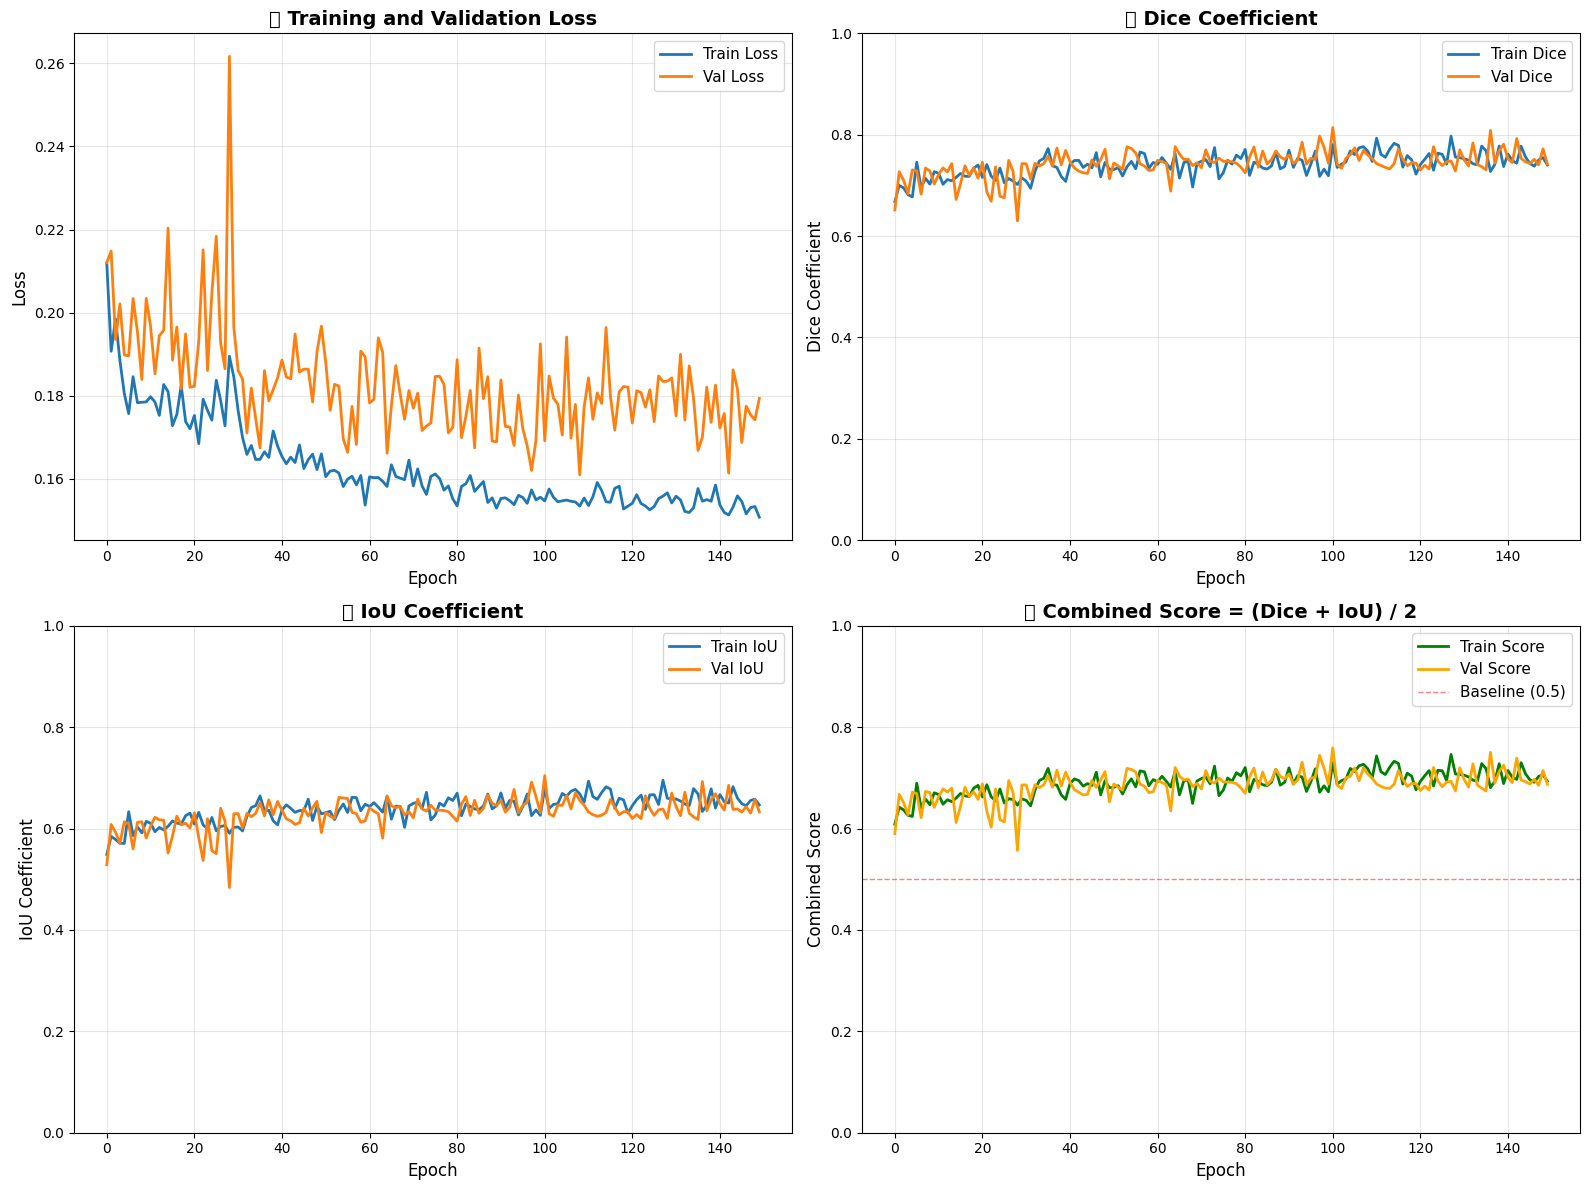

📊 訓練曲線已儲存到 training_curves.png


In [13]:
# 繪製訓練曲線
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('📉 Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Dice
axes[0, 1].plot(history['train_dice'], label='Train Dice', linewidth=2)
axes[0, 1].plot(history['val_dice'], label='Val Dice', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Dice Coefficient', fontsize=12)
axes[0, 1].set_title('🎯 Dice Coefficient', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# IoU
axes[1, 0].plot(history['train_iou'], label='Train IoU', linewidth=2)
axes[1, 0].plot(history['val_iou'], label='Val IoU', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('IoU Coefficient', fontsize=12)
axes[1, 0].set_title('📊 IoU Coefficient', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Combined Score
axes[1, 1].plot(history['train_score'], label='Train Score', linewidth=2, color='green')
axes[1, 1].plot(history['val_score'], label='Val Score', linewidth=2, color='orange')
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (0.5)')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Combined Score', fontsize=12)
axes[1, 1].set_title('🏆 Combined Score = (Dice + IoU) / 2', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print('📊 訓練曲線已儲存到 training_curves.png')


## 12. 測試最佳模型


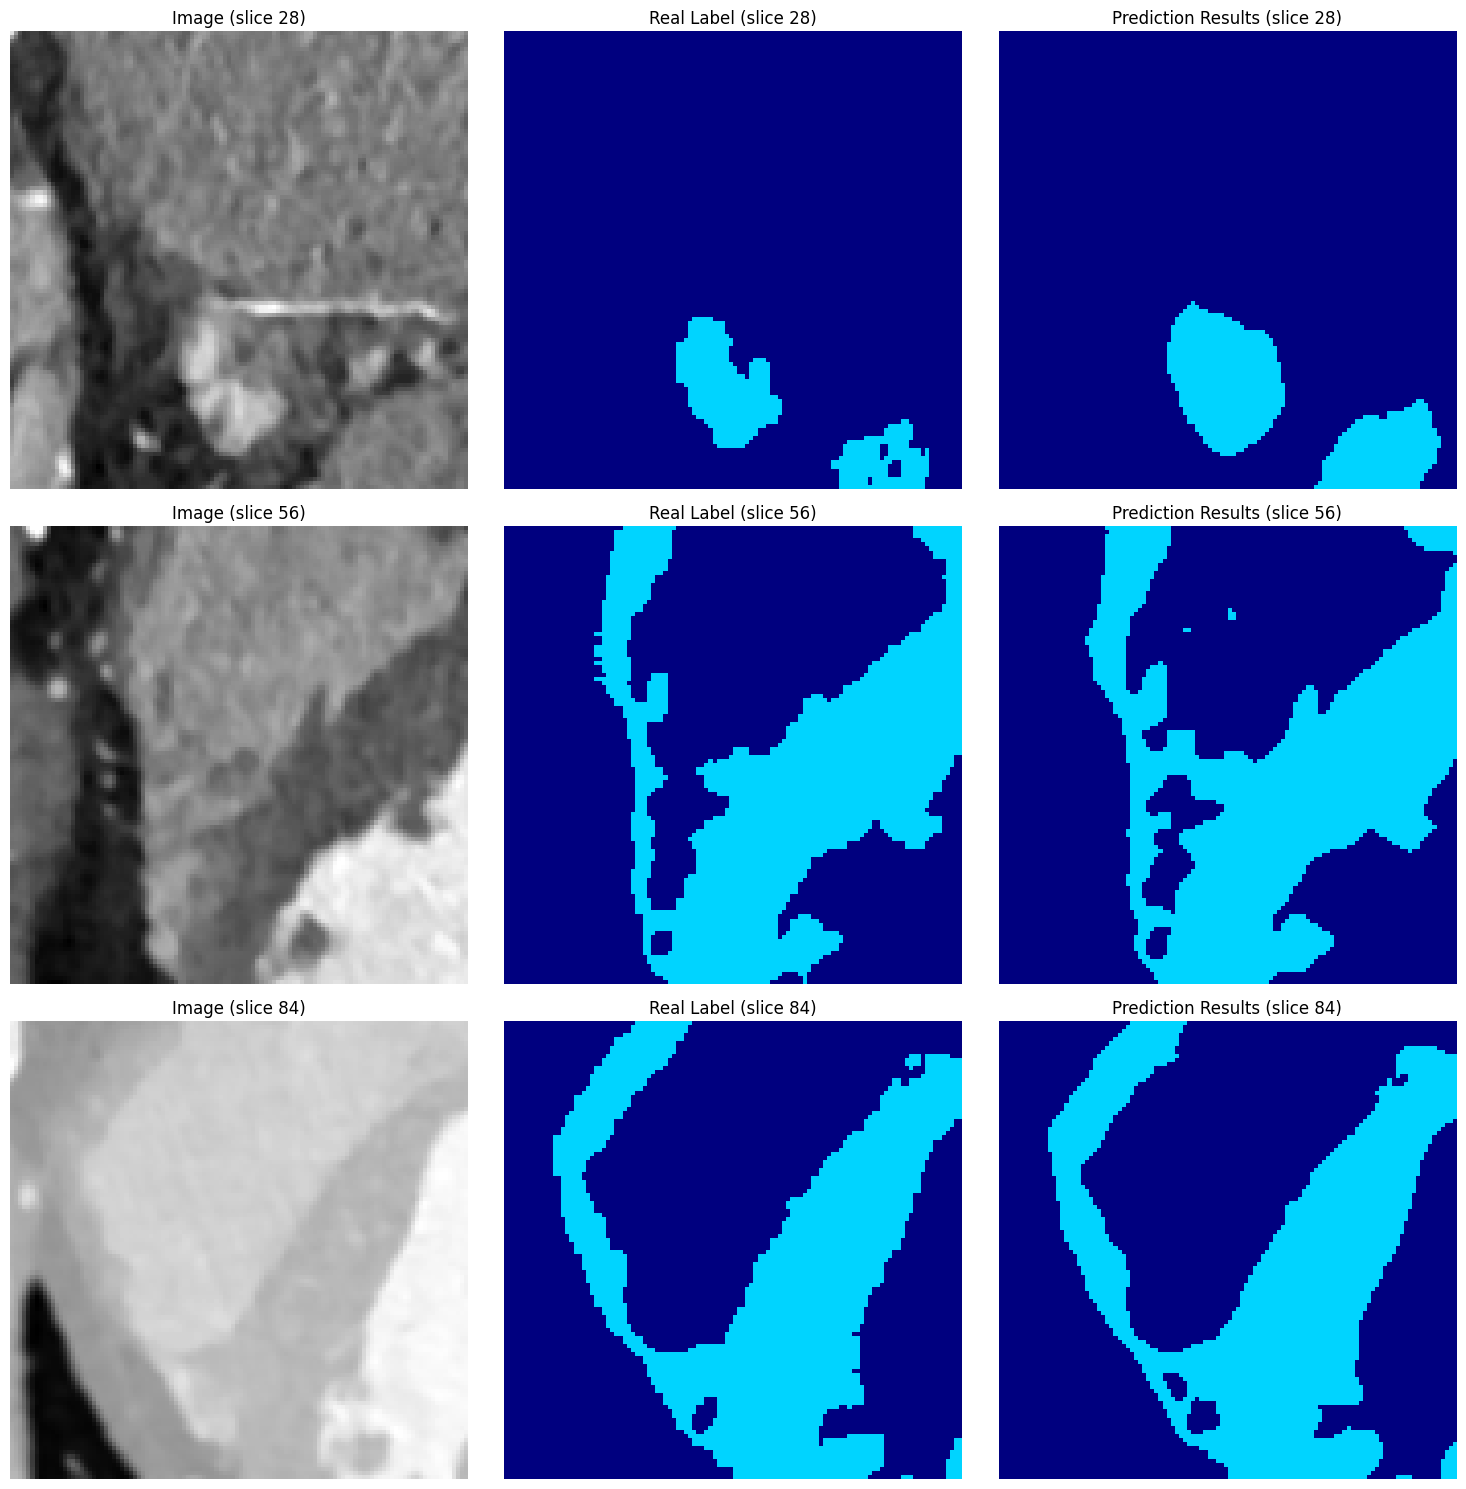

In [14]:
# 載入最佳模型
checkpoint = torch.load(os.path.join(SAVE_DIR, 'best_model.pth'), weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 視覺化驗證集的預測結果
val_image, val_label = val_dataset[0]
val_image_input = val_image.unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(val_image_input)
    prediction = torch.argmax(prediction, dim=1).cpu().numpy()[0]

val_image = val_image.cpu().numpy()[0]
val_label = val_label.numpy()

# 顯示三個不同的切片
slice_indices = [val_image.shape[-1] // 4, val_image.shape[-1] // 2, 3 * val_image.shape[-1] // 4]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, slice_idx in enumerate(slice_indices):
    axes[i, 0].imshow(val_image[:, :, slice_idx], cmap='gray')
    axes[i, 0].set_title(f'Image (slice {slice_idx})')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(val_label[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[i, 1].set_title(f'Real Label (slice {slice_idx})')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(prediction[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[i, 2].set_title(f'Prediction Results (slice {slice_idx})')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('validation_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
import os
import shutil

# 重新定義 Google Drive 的 base_data_dir
base_data_dir = '/content/gdrive/MyDrive/aicup_data'

# 定義結果儲存目錄
results_dir = os.path.join(base_data_dir, 'aicup_results')
os.makedirs(results_dir, exist_ok=True)

# 最佳模型儲存的路徑 (來自訓練過程)
# 假設 SAVE_DIR 在訓練時是 'checkpoints'
model_source_path = os.path.join('checkpoints', 'best_model.pth')
model_destination_path = os.path.join(results_dir, 'best_model.pth')

# 複製最佳模型到 Google Drive
if os.path.exists(model_source_path):
    shutil.copy(model_source_path, model_destination_path)
    print(f'✅ 已將最佳模型 \'{model_source_path}\' 複製到 \'{model_destination_path}\'')
else:
    print(f'❌ 找不到最佳模型檔案：\'{model_source_path}\'。請確認訓練是否成功完成並產生了該檔案。')


✅ 已將最佳模型 'checkpoints/best_model.pth' 複製到 '/content/gdrive/MyDrive/aicup_data/aicup_results/best_model.pth'
